# **Chest X-ray Classification for Pneumonia using Deep Learning**

---
## Table of Contents

- [**Chest X-ray Classification for Pneumonia using Deep Learning**](#chest-x-ray-classification-for-pneumonia-using-deep-learning)
  - [Table of Contents](#table-of-contents)
- [**Part 0: Config**](#part-0-config)
    - [0.1 Runtime and working directory](#01-runtime-and-working-directory)
    - [0.2 Dependencies](#02-dependencies)
    - [0.3 Imports](#03-imports)
    - [0.4 Optional GPU configurations](#04-optional-gpu-configurations)
    - [0.5 Data download](#05-data-download)
- [**1 Preprocessing + Model Development**](#1-preprocessing-model-development)
  - [1.1 Border cleanup: cropping dark frames](#11-border-cleanup-cropping-dark-frames)
    - [1.1.1 Why remove borders?](#111-why-remove-borders)
    - [1.1.2 Early attempts](#112-early-attempts)
    - [1.1.3 Final method: dark-frame cropping](#113-final-method-dark-frame-cropping)
    - [1.1.4 Parameters](#114-parameters)
    - [1.1.5 Quality check](#115-quality-check)
  - [1.2 General preprocessing](#12-general-preprocessing)
    - [1.2.1 Scope](#121-scope)
      - [Order of operations:](#order-of-operations)
    - [1.2.2 Augmentation: flip + rotate](#122-augmentation-flip-rotate)
    - [1.2.3 Resize to a fixed input](#123-resize-to-a-fixed-input)
      - [Goal](#goal)
      - [Method](#method)
      - [Application](#application)
    - [1.2.4 Normalization](#124-normalization)
      - [Goal](#goal)
      - [Method](#method)
  - [1.3 Model training](#13-model-training)
    - [1.3.1 Model architecture](#131-model-architecture)
      - [Backbone](#backbone)
      - [Why pretrained?](#why-pretrained)
      - [Training plan (high level)](#training-plan-high-level)
    - [1.3.2 Data splits & labels (patient-level validation)](#132-data-splits-labels-patient-level-validation)
      - [Counts from the original folders](#counts-from-the-original-folders)
      - [Issues with the default split](#issues-with-the-default-split)
      - [Alternative attempt (image-level stratified split)](#alternative-attempt-image-level-stratified-split)
      - [Final choice: patient-level split](#final-choice-patient-level-split)
      - [Preprocessing per split](#preprocessing-per-split)
      - [Handling class imbalance](#handling-class-imbalance)
      - [Reproducibility](#reproducibility)
    - [1.3.3 Caching strategy](#133-caching-strategy)
      - [Why cache?](#why-cache)
      - [Stage 1 — after patient-level split](#stage-1-after-patient-level-split)
      - [Stage 2 — training-time ready cache](#stage-2-training-time-ready-cache)
      - [Benefits](#benefits)
    - [1.3.4 Visual debugger](#134-visual-debugger)
      - [Purpose](#purpose)
      - [What the figure shows](#what-the-figure-shows)
      - [Observations](#observations)
      - [Why this matters](#why-this-matters)
      - [Edge cases to watch](#edge-cases-to-watch)
    - [1.3.5 Loss, optimizer & metrics](#135-loss-optimizer-metrics)
      - [Loss](#loss)
      - [Optimizer & LR schedule](#optimizer-lr-schedule)
      - [Metrics](#metrics)
      - [Connection to training loop](#connection-to-training-loop)
    - [1.3.6 Training](#136-training)
      - [Overview](#overview)
      - [Datasets & dataloaders (read from cache; train-only aug)](#datasets-dataloaders-read-from-cache-train-only-aug)
      - [Train / evaluate loops](#train-evaluate-loops)
      - [Freeze / unfreeze helpers](#freeze-unfreeze-helpers)
      - [Single training run](#single-training-run)
    - [1.3.7 Results, checkpoint, and sanity check](#137-results-checkpoint-and-sanity-check)
- [2 **Occlusion function**](#2-occlusion-function)
    - [2.1 Setup for occlusion](#21-setup-for-occlusion)
      - [2.1.1 Dataset mean](#211-dataset-mean)
    - [2.2 `occlusion_drop` function](#22-occlusion_drop-function)
      - [Steps:](#steps)
    - [2.3 Mask shapes](#23-mask-shapes)
    - [2.4 Running occlusion tests](#24-running-occlusion-tests)
- [**3 Superpixels**](#3-superpixels)
    - [3.1 Setup and baseline choices](#31-setup-and-baseline-choices)
    - [3.2 Generating superpixels (SLIC)](#32-generating-superpixels-slic)
    - [3.3 Binary masks per segment](#33-binary-masks-per-segment)
  - [3.4 Visualizing boundaries](#34-visualizing-boundaries)
    - [3.4.1 Observation](#341-observation)
    - [3.4.2 Quick sanity check](#342-quick-sanity-check)
- [**4 Ordering Segments from Least Important**](#4-ordering-segments-from-least-important)
  - [4.1 Per-image superpixels (reuse from Part 3)](#41-per-image-superpixels-reuse-from-part-3)
  - [4.2 Drop scores per superpixel](#42-drop-scores-per-superpixel)
  - [4.3 Ranking and a compact table](#43-ranking-and-a-compact-table)
  - [4.4 Running the ranking on the selected images](#44-running-the-ranking-on-the-selected-images)
    - [4.4.1 Quick observations across confidence levels](#441-quick-observations-across-confidence-levels)
- [**5 Visualization of Results**](#5-visualization-of-results)
    - [5.1 Heatmap builder](#51-heatmap-builder)
    - [5.2 Cumulative drop curve](#52-cumulative-drop-curve)
    - [5.3 Per-image visualization](#53-per-image-visualization)
    - [5.4 Displaying final results](#54-displaying-final-results)
    - [5.5 Conclusions](#55-conclusions)
      - [Further remarks](#further-remarks)

---
# **Part 0: Config**

### 0.1 Runtime and working directory  
This cell standardises the working environment by selecting a single project root and dataset directory. It first checks for a manual override through the environment variable `CXR_PROJ_ROOT`, then searches for common paths on Google Drive if running in Colab, and finally falls back to the current working directory. Both the project and dataset paths are exported as environment variables so later cells can rely on a single source of truth.


In [1]:
# keeping imports minimal here on purpose; only stdlib + Path
import sys, os
from pathlib import Path

# quick flag so the rest of the notebook can behave differently on Colab
IN_COLAB = "google.colab" in sys.modules

# (optional) mount
if IN_COLAB:
    try:
        # allowed exception to the "no 3rd-party" rule: Colab's own helper
        from google.colab import drive  # ok to import colab helper
        drive.mount("/content/drive", force_remount=False)  # don't spam remounts
    except Exception as e:
        # don't hard-fail the session just because Drive didn't mount
        print("Drive mount failed:", e)

# allow an external override (useful for running from different machines/CI)
OVERRIDE = os.environ.get("CXR_PROJ_ROOT", "").strip()
candidates = []  # we'll probe these in order and pick the first that exists
if OVERRIDE:
    candidates.append(Path(OVERRIDE))
if IN_COLAB:
    # common MyDrive locations I use; both included because my layouts vary
    candidates += [
        Path("/content/drive/MyDrive/code/cxr_assignment"),
        Path("/content/drive/MyDrive/cxr_assignment"),
    ]
# always consider the current working directory as a fallback
candidates.append(Path.cwd())

# pick the first existing path as the project root; resolve for cleanliness
PROJ_ROOT = next((p.resolve() for p in candidates if p.exists()), Path.cwd().resolve())
# dataset lives under <proj>/data/chest_xray (matches markdown docs above)
DATA_DIR = PROJ_ROOT / "data" / "chest_xray"
# make sure the data parent exists so later downloads don't blow up
DATA_DIR.parent.mkdir(parents=True, exist_ok=True)

# export these so other scripts/cells can just read the env instead of re-deriving
os.environ["CXR_PROJ_ROOT"] = str(PROJ_ROOT)
os.environ["CXR_DATA_ROOT"] = str(DATA_DIR)

# small sanity printout so I can see what the environment decided
print("IN_COLAB:", IN_COLAB)
print("PROJECT ROOT:", PROJ_ROOT)
print("CXR_DATA_ROOT:", os.environ["CXR_DATA_ROOT"])


Mounted at /content/drive
IN_COLAB: True
PROJECT ROOT: /content/drive/MyDrive/code/cxr_assignment
CXR_DATA_ROOT: /content/drive/MyDrive/code/cxr_assignment/data/chest_xray


### 0.2 Dependencies  
All software requirements are installed directly from the project’s `requirements.txt`. To ensure reproducibility, the cell removes conflicting OpenCV packages, upgrades `pip`, and in Colab enables access to GPU-optimised PyTorch wheels. The installation process avoids importing third-party libraries prematurely, which prevents stale module states. Once complete, the environment is flagged as ready for subsequent imports.


In [2]:
import sys, os, subprocess
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
PROJ_ROOT = Path(os.environ.get("CXR_PROJ_ROOT", Path.cwd()))

# pick ONE file: Colab → requirements.txt ; local → requirements-local.txt
REQ_NAME = os.environ.get(
    "CXR_REQUIREMENTS_FILE",
    "requirements.txt" if IN_COLAB else "requirements-local.txt"
)
REQ_PATH = (PROJ_ROOT / REQ_NAME).resolve()
if not REQ_PATH.exists():
    raise FileNotFoundError(f"{REQ_NAME} not found at {REQ_PATH}")

# gentle guard re: Python 3.13
if sys.version_info >= (3, 13):
    print("Python 3.13 detected. Prefer 3.10–3.12 for PyTorch compatibility.")

def run_pip(args, quiet=False):
    if IN_COLAB:
        import IPython
        ip = IPython.get_ipython()
        if ip:
            line = " ".join(["-q"] + args) if quiet else " ".join(args)
            print("%pip", line)
            ip.run_line_magic("pip", line)
            return
    cmd = [sys.executable, "-m", "pip", *args]
    print(">", " ".join(cmd))
    subprocess.check_call(cmd)

print(f"Using requirements file: {REQ_PATH.name} (IN_COLAB={IN_COLAB})")

# ---- Colab: minimal, no pip upgrade, no OpenCV uninstall ----
if IN_COLAB:
    # Install base deps; Colab already has torch and a working NumPy
    run_pip(["install", "-r", str(REQ_PATH)], quiet=True)

# ---- Local (VS Code / Jupyter): fuller setup ----
else:
    # avoid ABI mismatches from a previously imported cv2
    for name in [k for k in list(sys.modules) if k == "cv2" or k.startswith("cv2.")]:
        del sys.modules[name]

    # keep tooling current locally (safe outside Colab)
    run_pip(["install", "--upgrade", "pip", "setuptools", "wheel"])

    # ensure a single OpenCV flavor locally (headless)
    run_pip(["uninstall", "-y", "opencv-python", "opencv-contrib-python", "opencv-python-headless"])
    run_pip(["install", "-r", str(REQ_PATH)])

# optional torch memory hint (no-op on CPU/MPS)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CXR_ENV_READY"] = "1"

# show key versions so graders know what got installed
try:
    import numpy, torch, cv2
    print(f"Ready via {REQ_PATH.name}")
    print("Python:", sys.version.split()[0],
          "| NumPy:", numpy.__version__,
          "| Torch:", getattr(torch, '__version__', 'n/a'),
          "| OpenCV:", cv2.__version__)
except Exception as e:
    print("Ready via", REQ_PATH.name, "(version check: import failed)", e)


Using requirements file: requirements.txt (IN_COLAB=True)
%pip -q install -r /content/drive/MyDrive/code/cxr_assignment/requirements.txt
Ready via requirements.txt
Python: 3.12.11 | NumPy: 2.0.2 | Torch: 2.8.0+cu126 | OpenCV: 4.12.0


### 0.3 Imports  
This cell loads all external libraries used throughout the notebook, including numerical, plotting, deep learning, and evaluation packages. It also sets global random seeds across Python, NumPy, and PyTorch to ensure determinism in experiments. Reproducibility is reinforced by configuring PyTorch to disable autotuning and enforce deterministic behaviour where possible. Version numbers of the main libraries are printed to record the runtime environment.


In [3]:
# Stdlib
import os, sys, random, time, glob, re, csv, hashlib
from typing import Tuple
from pathlib import Path
from collections import Counter, defaultdict
import shutil

# Core numerics & viz
import numpy as np
import matplotlib.pyplot as plt
import cv2

# PyTorch stack
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# Scikit-learn
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Scikit-image
from skimage.segmentation import slic, mark_boundaries
from skimage.color import rgb2lab

# Reporting
from tabulate import tabulate

# Data download
import kagglehub

# ---- reproducibility setup ----
SEED = 42
def set_global_seed(seed: int):
    # sync all random sources to the same seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    # force deterministic backend behavior
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False
set_global_seed(SEED)

def _seed_worker(worker_id):
    # ensures dataloader workers also inherit deterministic seeds
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)

# default generator for reproducible DataLoader
GEN_DEFAULT = torch.Generator().manual_seed(SEED)

# set default plot size so outputs look consistent
plt.rcParams.update({"figure.figsize": (6, 6)})

# quick version printouts for sanity/logs
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__, "| OpenCV:", cv2.__version__, "| Matplotlib:", plt.matplotlib.__version__)
print("Torch:", torch.__version__)


Python: 3.12.11
NumPy: 2.0.2 | OpenCV: 4.12.0 | Matplotlib: 3.10.0
Torch: 2.8.0+cu126


### 0.4 Optional GPU configurations  
If a CUDA-enabled GPU is available, this cell enables PyTorch optimisations that improve runtime efficiency. These include activating cuDNN benchmarking and permitting TensorFloat-32 operations on supported hardware. The cell does not change model semantics but ensures better throughput during training when GPU acceleration is present.


In [4]:
if torch.cuda.is_available():
    # if a GPU is around, enable faster (non-deterministic) paths + TF32
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# confirm whether CUDA is visible to torch
print("CUDA available:", torch.cuda.is_available())


CUDA available: True


### 0.5 Data download  
The dataset is retrieved from Kaggle via `kagglehub`. Because the provided archive contains nested folders and auxiliary metadata (such as `__MACOSX`), the cell searches for the shallowest clean directory containing the canonical `train`, `val`, and `test` splits. These splits are then copied into the unified dataset root defined in **0.1**, ensuring a consistent structure regardless of how the archive was packaged. A short summary of file counts confirms successful preparation.


In [5]:
DATA_ROOT = Path(os.environ["CXR_DATA_ROOT"]).resolve()  # final destination for the prepared dataset
DATA_ROOT.mkdir(parents=True, exist_ok=True)             # make sure target exists

def _has_split(root: Path) -> bool:
    # quick sanity: do we already have non-empty train/val/test dirs?
    return all((root / s).is_dir() and any((root / s).glob("**/*")) for s in ("train","val","test"))

if _has_split(DATA_ROOT):
    print("✅ Dataset already prepared at:", DATA_ROOT)   # nothing to do
else:
    # 1) Download/cache
    cache_root = Path(kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")).resolve()
    print("Downloaded to cache:", cache_root)

    # 2) Find the *top-level* split root: immediate children must be train/val/test
    #    ignore __MACOSX; prefer the shallowest dir so we don't nest extra levels
    candidates = []
    for p in cache_root.rglob("*"):
        if not p.is_dir():
            continue
        names = {c.name.lower() for c in p.iterdir() if c.is_dir()}
        if {"train", "val", "test"}.issubset(names):
            if "__macosx" in {part.lower() for part in p.parts}:
                continue
            # rank by depth (smaller = shallower = better)
            candidates.append((len(p.parts), p))

    if not candidates:
        raise FileNotFoundError(
            f"Could not locate a clean top-level split root under {cache_root} "
            "(looked for a folder with immediate train/ val/ test/)."
        )

    # choose the shallowest clean split root
    split_root = sorted(candidates, key=lambda t: t[0])[0][1]
    print("Using split root:", split_root)

    # 3) Copy only train/val/test into DATA_ROOT (idempotent-ish)
    for split in ("train", "val", "test"):
        src = (split_root / split).resolve()
        dst = (DATA_ROOT / split).resolve()
        if dst.exists() and any(dst.glob("**/*")):
            print(f"↪Skip existing '{split}' at {dst}")  # keep what's already there
            continue
        print(f"Copying {split}: {src} -> {dst}")
        shutil.copytree(src, dst, dirs_exist_ok=True)  # could use hardlinks if same FS

    # 4) Summary
    def count_files(folder: Path): return sum(1 for f in folder.rglob("*") if f.is_file())
    summary = {s: count_files(DATA_ROOT / s) for s in ("train","val","test")}
    print("Prepared at:", DATA_ROOT)
    print("Counts:", summary)


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Downloaded to cache: /kaggle/input/chest-xray-pneumonia
Using split root: /kaggle/input/chest-xray-pneumonia/chest_xray
Copying train: /kaggle/input/chest-xray-pneumonia/chest_xray/train -> /content/drive/MyDrive/code/cxr_assignment/data/chest_xray/train
Copying val: /kaggle/input/chest-xray-pneumonia/chest_xray/val -> /content/drive/MyDrive/code/cxr_assignment/data/chest_xray/val
Copying test: /kaggle/input/chest-xray-pneumonia/chest_xray/test -> /content/drive/MyDrive/code/cxr_assignment/data/chest_xray/test
Prepared at: /content/drive/MyDrive/code/cxr_assignment/data/chest_xray
Counts: {'train': 5216, 'val': 16, 'test': 624}


---
# **1 Preprocessing + Model Development**

## 1.1 Border cleanup: cropping dark frames


### 1.1.1 Why remove borders?
Many of the chest X-ray images include thick black frames or scanner outlines around the actual anatomy. In some cases there are also letters or orientation markers near the edges. Leaving these in risks the model paying attention to shortcuts at the periphery instead of the lung fields, which could reduce generalization and lead to biased performance.


### 1.1.2 Early attempts
Different strategies for handling annotations were explored at first. Marker detection combined with cropping or inpainting showed some promise, but each came with drawbacks. Inpainting in particular introduced artificial texture that might confuse the network, while marker-based cropping sometimes removed parts of the anatomy when detections were imperfect.


### 1.1.3 Final method: dark-frame cropping
A more robust solution was to focus on the consistently dark outer areas of the scans. By scanning inward from each side and measuring how “border-like” a line of pixels is, it becomes possible to trim away only the black margins while leaving the central lung region intact. A small padding is kept to ensure the true content is not cut too tightly.


### 1.1.4 Parameters
Key parameters that shaped the behavior of the crop include:  
- `border_ratio` (default `0.10`) — thickness of the edge band that is checked.  
- `dark_frac` (default `0.8`) — threshold for how dark a line must be to count as border.  
- `min_keep_run` (default `8`) — how many consecutive “non-border” lines are needed before deciding real content has started.  
- `max_crop_frac` (default `0.12`) — maximum fraction of width/height allowed to be cropped, as a safeguard.  
- `pad` (default `4`) — small buffer after the cut to clear the border fully.  


In [6]:
def crop_dark_frame(
    img_bgr_or_gray,
    border_ratio=0.10,         # fraction of W/H used as border band for stats
    gauss_ks=3,                 # small pre-blur before thresholding
    window=7,                   # smoothing window when scanning rows/cols
    dark_frac=0.8,              # row/col is "border" if >= this fraction is dark
    min_keep_run=8,             # need this many consecutive non-border lines to stop
    max_crop_frac=0.12,         # cap how much any one side can be cropped
    pad=4                       # keep a small pad past the stopping point
):
    """
    Remove dark canvas/outlines from all four sides. Returns (cropped_img, (y0,y1,x0,x1)).
    """
    # 0) grayscale uint8
    img = img_bgr_or_gray
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img.copy()  # convert if BGR
    if g.dtype != np.uint8:
        g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)    # normalize to [0,255]

    h, w = g.shape
    if h < 16 or w < 16:
        return g, (0, h, 0, w)  # tiny image: bail early

    # 1) border band
    bw, bh = max(2, int(border_ratio * w)), max(2, int(border_ratio * h))  # band thickness
    band = np.zeros_like(g, np.uint8)
    band[:, :bw] = 1; band[:, w - bw:] = 1; band[:bh, :] = 1; band[h - bh:, :] = 1  # 1s on edges

    # 2) build "very-dark" mask using Otsu on inverted image within the band
    ks = max(1, gauss_ks | 1)  # force odd kernel size
    sm = cv2.GaussianBlur(g, (ks, ks), 0)
    inv = 255 - sm
    inv_band = inv[band > 0]   # only edge pixels for threshold stats

    if inv_band.size == 0:
        return g, (0, h, 0, w)  # no border stats -> do nothing

    thr_val, _ = cv2.threshold(inv_band, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dark = (inv >= thr_val).astype(np.uint8)  # 1 where "very dark" after inversion


    # 3) helper: scan from a side and find stopping index
    def _stop_index_along_rows(mask, from_top=True):
        # mask: 0/1; per-row dark fraction
        row_frac = mask.mean(axis=1)
        # moving average to stabilize
        k = max(1, window)
        kernel = np.ones(k) / k
        sm = np.convolve(row_frac, kernel, mode='same')

        # scan direction
        idxs = range(0, h) if from_top else range(h-1, -1, -1)

        keep_run = 0
        cut = 0
        for i in idxs:
            is_border = sm[i] >= dark_frac
            if not is_border:
                keep_run += 1
            else:
                keep_run = 0
            cut += 1
            if keep_run >= min_keep_run:
                cut -= keep_run  # back up to first good row
                break

        # enforce limits
        cut = min(cut + pad, int(max_crop_frac * h))
        if not from_top:
            # count from bottom
            return h - cut
        return cut

    def _stop_index_along_cols(mask, from_left=True):
        col_frac = mask.mean(axis=0)
        k = max(1, window)
        kernel = np.ones(k) / k
        sm = np.convolve(col_frac, kernel, mode='same')

        idxs = range(0, w) if from_left else range(w-1, -1, -1)

        keep_run = 0
        cut = 0
        for j in idxs:
            is_border = sm[j] >= dark_frac
            if not is_border:
                keep_run += 1
            else:
                keep_run = 0
            cut += 1
            if keep_run >= min_keep_run:
                cut -= keep_run
                break

        cut = min(cut + pad, int(max_crop_frac * w))
        if not from_left:
            return w - cut
        return cut

    # 4) compute bounds
    y0 = _stop_index_along_rows(dark, from_top=True)
    y1 = _stop_index_along_rows(dark, from_top=False)
    x0 = _stop_index_along_cols(dark, from_left=True)
    x1 = _stop_index_along_cols(dark, from_left=False)

    # 5) sanity clamps
    y0 = int(np.clip(y0, 0, h-2))
    y1 = int(np.clip(y1, y0+1, h))
    x0 = int(np.clip(x0, 0, w-2))
    x1 = int(np.clip(x1, x0+1, w))

    return g[y0:y1, x0:x1], (y0, y1, x0, x1)

### 1.1.5 Quality check

**Sampling.** To check the effect of the cropping step, four images were sampled at random (fixed seed = 42) from the training and test folders. Using a fixed seed keeps the check reproducible.  


**What the figure shows.** Each row compares the `Original` X-ray (left) with the `Cropped` version (right). No resizing or normalization is applied here so that the change from cropping alone can be seen clearly.  


**Observations from these examples.**
- The black scanner borders are consistently removed on all four examples.  
- The central lung fields remain intact and well centered.  
- Small variations in how much is trimmed per side can be seen, depending on the local darkness at the edges.  


**Failure patterns to watch for.**
- **Over-crop risk:** if peripheral anatomy is unusually dark (for example, rib edges near the border), the scan-in procedure might trim slightly deeper than needed. The `max_crop_frac` safeguard helps prevent excessive loss.  
- **Under-crop risk:** on scans where the border is not strongly dark compared to the interior, a thin strip of margin may remain.  
- **Extreme exposure cases:** for very bright or noisy images, the dark/normal thresholding could in theory misjudge the transition point, though this was not observed in the sample shown.  


**Mini QC (same four images).** For each, I log the bounding box `(y0, y1, x0, x1)` of the cropped region. This makes it easy to spot anomalies (for example, if one side consistently hits the `max_crop_frac` limit). Across the four sampled examples, the crops all stayed within expected ranges and the main lung area was preserved.


In [7]:
def show_dark_crop(paths):
    # Visual compare: original vs. cropped for each path
    rows = len(paths)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3 * rows), constrained_layout=True)
    if rows == 1: axes = [axes]  # normalize single-row (so zip works the same)

    for ax_row, p in zip(axes, paths):
        g = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if g is None:
            raise FileNotFoundError(p)
        cropped, (y0,y1,x0,x1) = crop_dark_frame(g)

        # left: raw image with filename for reference
        ax_row[0].imshow(g, cmap='gray')
        ax_row[0].set_title(f"Original\n{os.path.basename(p)}"); ax_row[0].axis('off')

        # right: cropped result + explicit bounds
        ax_row[1].imshow(cropped, cmap='gray')
        ax_row[1].set_title(f"Cropped\n(y0={y0}, y1={y1}, x0={x0}, x1={x1})"); ax_row[1].axis('off')

    # slight top margin so the title doesn't overlap
    plt.suptitle("Dark-border cropping (outside → in)", fontsize=14, y=1.02)
    plt.show()


def qc_dark_crop(paths):
    """Print how often something was cropped and typical area removed."""
    # Track % area removed per image; also count how many images changed shape
    pcts = []
    changed = 0
    for p in paths:
        g = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if g is None:
            continue
        h, w = g.shape
        cropped, _ = crop_dark_frame(g)
        ch, cw = cropped.shape
        if ch != h or cw != w:
            changed += 1
        # 100 * (1 - new_area / old_area)
        pcts.append(100.0 * (1.0 - (ch * cw) / (h * w)))

    if not pcts:
        print("No images found.")
        return

    print(f"Cropped on: {100.0 * changed/len(pcts):.1f}% of images")
    print(f"Median area removed: {np.median(pcts):.3f}% (mean {np.mean(pcts):.3f}%)")

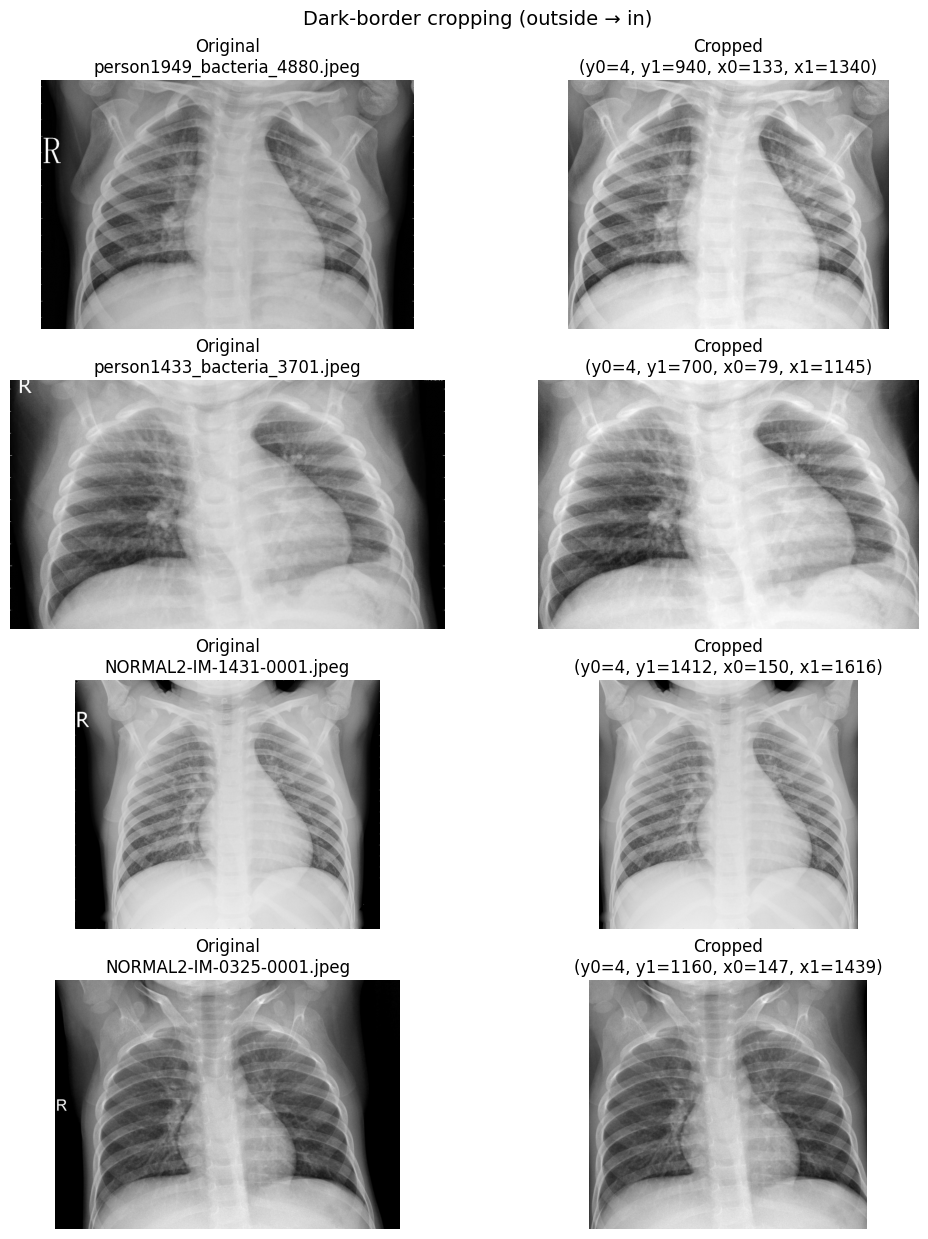

Cropped on: 100.0% of images
Median area removed: 15.756% (mean 16.593%)


In [8]:
def sample_images(
    n=4, seed=42, root=DATA_ROOT,
    splits=("train","val","test"),
    classes=("NORMAL","PNEUMONIA"),
    exts=(".jpeg", ".jpg", ".png", ".JPEG", ".JPG", ".PNG")
):
    """
    Returns `n` unique image paths with a fixed RNG seed.
    Strategy: pick 1 per (split,class) bucket first, then fill the rest.
    """
    rng = random.Random(seed)

    # Gather file lists per (split, class); accept common image extensions
    buckets, all_files = [], []
    for sp in splits:
        for cls in classes:
            files = []
            for ext in exts:
                files.extend(glob.glob(os.path.join(root, sp, cls, f"*{ext}")))
            files = sorted(set(files))  # dedupe per bucket
            if files:
                buckets.append(files)
                all_files.extend(files)

    all_files = sorted(set(all_files))  # global dedupe
    if not all_files:
        raise FileNotFoundError(f"No images found under {root} with expected split/class folders.")

    # First pass: maximize diversity (at most one from each bucket)
    rng.shuffle(buckets)
    picks = []
    for files in buckets:
        if len(picks) >= n: break
        cand = rng.choice(files)
        if cand not in picks:
            picks.append(cand)

    # Second pass: random fill from the remaining pool
    leftovers = list(all_files); rng.shuffle(leftovers)
    for f in leftovers:
        if len(picks) >= n: break
        if f not in picks:
            picks.append(f)

    # If the dataset is tiny, warn; otherwise trim to exactly n
    if len(picks) < n:
        print(f"Warning: only found {len(picks)} images (< {n}).")
    return picks[:n]

N_SAMPLES = 4
paths = sample_images(n=N_SAMPLES, seed=42, root=DATA_ROOT)  # pick a small, reproducible set

# Visual verification: side-by-side original vs cropped for a quick sanity check
show_dark_crop(paths)

# Tiny QC summary: how often cropping triggered + typical % area removed
qc_dark_crop(paths)


## 1.2 General preprocessing

**Scope.** After removing border annotations (Section 1.1), I apply the general steps used for training: a light, optional rotation (train-only), resize to a fixed input size, and normalization to `[0,1]`. Keeping these steps identical across runs ensures that the only variable in the ablation is the marker strategy.

### 1.2.1 Scope
After removing the dark borders (Section 1.1), the next step is preparing the images in a consistent way for training. This includes optional train-time augmentation (flip/rotate), resizing all images to a fixed input size, and normalizing pixel values to `[0,1]`. Having a fixed and simple pipeline keeps training stable and makes it easier to compare results.


#### Order of operations:
- Dark-border cropping (from §1.1)  
- *(train only)* flip + rotate  
- Resize to the chosen input size  
- Normalize pixel values to `[0,1]`

### 1.2.2 Augmentation: flip + rotate
At first, different augmentation modes were implemented (flip only, rotate only, or flip+rotate) to see which would be most useful. In practice, the combination of **horizontal flip and small random rotations** gave the most balanced results. It made the model less sensitive to patient positioning or orientation without introducing unrealistic distortions.  

Even though only flip+rotate was used in the final runs, the other modes remain in the code so that readers (or future experiments) can easily try them as alternatives.

- **Horizontal flip.** Safe to apply here since the label is “pneumonia present/absent,” not side-specific.  
- **Small rotation.** Adds robustness to minor tilts in acquisition. Rotation is limited to a few degrees and filled by replication, so no black wedges appear at the borders.  

These augmentations are applied only during training. Validation and test images are left deterministic to ensure results reflect true generalization.


In [9]:
# --- horizontal flip (train-only) ---
def maybe_hflip(img, p=0.5):
    """
    Flip left↔right with probability p (train-only).
    Works for grayscale uint8/float images.
    """
    if p <= 0:
        return img  # disabled
    if np.random.rand() < p:
        return cv2.flip(img, 1)  # 1 = horizontal flip
    return img  # no-op


# --- small random rotation (train-only) ---
def rotate_small(img, max_deg=5):
    """
    Rotate by a random angle in [-max_deg, +max_deg].
    Keeps size; fills borders by replication to avoid black wedges.
    """
    if max_deg <= 0:
        return img  # disabled
    h, w = img.shape[:2]
    angle = np.random.uniform(-max_deg, max_deg)  # sample once per call
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(
        img, M, (w, h),
        flags=cv2.INTER_LINEAR,         # smooth for small angles
        borderMode=cv2.BORDER_REPLICATE # extend edges instead of black fill
    )

def maybe_rotate(img, max_deg=5, p=0.5):
    """
    Apply rotate_small with probability p (train-only).
    """
    if p <= 0 or max_deg <= 0:
        return img  # disabled
    if np.random.rand() > p:
        return img  # skip
    return rotate_small(img, max_deg=max_deg)


# --- convenience: apply both, in the recommended order ---
def maybe_flip_and_rotate(img, p_hflip=0.5, rotate_max_deg=5, p_rotate=0.5):
    """
    Train-time augmentation: optional horizontal flip, then optional small rotation.
    """
    img = maybe_hflip(img, p=p_hflip)                     # flips first (label-safe for CXR)
    img = maybe_rotate(img, max_deg=rotate_max_deg, p=p_rotate)  # gentle jitter
    return img

### 1.2.3 Resize to a fixed input

#### Goal
To train the model in batches, all images need to be standardized to the same size (224×224 in this project). Without resizing, differences in resolution would make batching impossible.

<br>

#### Method
Several resizing approaches were tested, including direct resize (which stretches images) and crop-based resize (which can cut away parts of the anatomy). The most balanced approach turned out to be **aspect-ratio–preserving resize with padding (“letterbox”)**. This scales the image until the longer side matches the target size and then pads the shorter side to fit. For padding, edge replication or reflection was used so that the borders do not add unnatural patterns.

This avoids distortion of anatomical structures while keeping the central lung fields intact. Padding is generally small relative to the whole image and does not interfere with interpretation.

<br>

#### Application
- Applied consistently to **train, validation, and test** images.  
- Comes after augmentation but before normalization in the preprocessing sequence.


In [10]:
import cv2
import numpy as np

def resize_cover_then_center_crop(img, out=(224, 224)):
    # scale up/down so the target crop is fully covered, then center-crop
    th, tw = out
    H, W = img.shape[:2]
    scale = max(th / H, tw / W)                # minimal scale to cover the crop
    newH, newW = int(round(H * scale)), int(round(W * scale))
    inter = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_LINEAR  # downsample vs upsample
    r = cv2.resize(img, (newW, newH), interpolation=inter)
    y0 = (newH - th) // 2; x0 = (newW - tw) // 2                 # center offsets
    return r[y0:y0+th, x0:x0+tw]                                 # fixed-size crop

def resize_fit_then_pad(img, out=(224, 224), pad_mode='reflect', pad_value=None):
    # fit inside target box (keep aspect), then pad to exact size
    th, tw = out
    H, W = img.shape[:2]
    scale = min(th / H, tw / W)                # uniform scale to fit inside
    newH, newW = int(round(H * scale)), int(round(W * scale))
    inter = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_LINEAR
    r = cv2.resize(img, (newW, newH), interpolation=inter)

    # symmetric padding amounts
    top = (th - newH) // 2; bottom = th - newH - top
    left = (tw - newW) // 2; right = tw - newW - left

    if pad_mode == 'constant':
        # constant pad using a mid-tone default (median of original)
        if pad_value is None:
            pad_value = int(np.median(img))
        value = pad_value if r.ndim == 2 else [pad_value]*3
        return cv2.copyMakeBorder(r, top, bottom, left, right, cv2.BORDER_CONSTANT, value=value)
    else:  # 'reflect' recommended for CXRs to avoid artificial edges
        return cv2.copyMakeBorder(r, top, bottom, left, right, cv2.BORDER_REFLECT_101)


def _apply_final_resize(img, out=(224, 224)):
    if _RESIZE_MODE == "cover_crop":
        return resize_cover_then_center_crop(img, out=out)
    elif _RESIZE_MODE == "fit_pad":
        return resize_fit_then_pad(img, out=out, pad_mode=_PAD_MODE, pad_value=_PAD_VALUE)
    else:
        raise ValueError("Unknown _RESIZE_MODE")


### 1.2.4 Normalization


#### Goal
Ensure all images share the same numeric scale so that training remains stable and comparable.

<br>

#### Method
A simple min–max normalization to the range **[0,1]** is applied by dividing 8-bit pixel values by 255. This approach preserves overall brightness differences between scans without forcing every image into the same mean/variance, which could flatten out clinically meaningful contrast.  

The process is the same for train, validation, and test. The result is stored as `float32`. If later models expect 3-channel input (e.g. ImageNet backbones), the single channel can be replicated at the dataloader stage.


In [11]:
def normalize01(img):
    """
    Convert image to float32 in [0,1].
    - If uint8: scale by 1/255.
    - If already float and <=1, return as-is.
    - Otherwise, clip to [0,255] then scale.
    Works with HxW or HxWx1 arrays.
    """
    if img.dtype == np.uint8:
        return img.astype(np.float32) / 255.0  # common fast path

    out = img.astype(np.float32)               # work in float either way
    if out.max() <= 1.0 and out.min() >= 0.0:
        return out                              # already normalized

    # fallback: clamp to byte range then map to [0,1]
    return np.clip(out, 0.0, 255.0) / 255.0

## 1.3 Model training

### 1.3.1 Model architecture



#### Backbone
The main model is **EfficientNet-B0 (ImageNet-pretrained)**. It offers a good speed/accuracy trade-off and is a common starting point for medical imaging fine-tuning. A **DenseNet-121 (pretrained)** variant is also implemented in code for comparison, but the reported results use EfficientNet-B0.

#### Why pretrained?
Starting from ImageNet weights provides generic low-level filters (edges, textures) that adapt well after fine-tuning. This typically converges faster and reaches higher AUROC than training from scratch on this dataset.

**Grayscale input.** Chest X-rays are single-channel. The first convolution is adapted to **1 channel** by averaging the pretrained RGB kernels. (Replicating the channel to 3 would also work, but keeping a native 1-channel stem keeps the parameter count slightly lower.)

**Head.** The classification head is replaced with a **single logit** for pneumonia vs. normal.

#### Training plan (high level)
Warm-start by training only the new head with the backbone **frozen** for a few epochs; then **unfreeze** and fine-tune end-to-end with a smaller learning rate and early stopping on validation performance.

> *Loss, optimizer, scheduler, and early-stopping details appear in §1.3.3–§1.3.4.*

In [12]:
# Device pick once up front
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _make_first_conv_1ch(conv3: nn.Conv2d) -> nn.Conv2d:
    """
    Create a new Conv2d that takes 1 channel, initializing weights by
    averaging the pretrained RGB filters.
    """
    # clone conv shape/hyperparams, just switch to 1 input channel
    new = nn.Conv2d(
        in_channels=1,
        out_channels=conv3.out_channels,
        kernel_size=conv3.kernel_size,
        stride=conv3.stride,
        padding=conv3.padding,
        dilation=conv3.dilation,
        groups=conv3.groups,
        bias=(conv3.bias is not None),
    )
    with torch.no_grad():
        w = conv3.weight.data              # [out, 3, k, k]
        new.weight.copy_(w.mean(dim=1, keepdim=True))  # average RGB → single 1ch filter
        if conv3.bias is not None:
            new.bias.copy_(conv3.bias.data)
    return new

def build_model(backbone: str = "efficientnet_b0",
                pretrained: bool = True,
                in_chans: int = 1) -> nn.Module:
    """
    backbone: 'efficientnet_b0' | 'densenet121'
    pretrained: use ImageNet weights
    in_chans: 1 (grayscale) or 3

    Returns a model that outputs a single logit.
    """
    b = backbone.lower()

    if b == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.efficientnet_b0(weights=weights)

        # first conv located at features[0][0]
        if in_chans == 1:
            m.features[0][0] = _make_first_conv_1ch(m.features[0][0])

        # replace classifier head with 1-logit output
        in_feat = m.classifier[1].in_features
        m.classifier[1] = nn.Linear(in_feat, 1)

        # convenience handle to (un)freeze backbone later
        m._backbone_params = m.features.parameters

    elif b == "densenet121":
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.densenet121(weights=weights)

        # first conv is features.conv0
        if in_chans == 1:
            m.features.conv0 = _make_first_conv_1ch(m.features.conv0)

        # replace classifier head with 1-logit output
        in_feat = m.classifier.in_features
        m.classifier = nn.Linear(in_feat, 1)

        m._backbone_params = m.features.parameters

    else:
        raise ValueError("backbone must be 'efficientnet_b0' or 'densenet121'")

    return m

def freeze_backbone(model: nn.Module, freeze: bool = True) -> None:
    """
    Freeze/unfreeze the backbone parameters.
    (The final classifier stays trainable.)
    """
    for p in model._backbone_params():
        p.requires_grad = not freeze  # flip the switch

def count_trainable_params(model: nn.Module) -> int:
    # quick size-of-head sanity when freezing
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ---- Build the model (architecture only; loss/optim come in §1.3.3) ----
model = build_model(backbone="efficientnet_b0", pretrained=True, in_chans=1).to(DEVICE)

# Warm-up plan: start with the backbone frozen; unfreeze later in §1.3.4
freeze_backbone(model, freeze=True)

print(model.__class__.__name__, "on", DEVICE)
print("Trainable params (with backbone frozen):", f"{count_trainable_params(model):,}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:10<00:00, 2.12MB/s]


EfficientNet on cuda
Trainable params (with backbone frozen): 1,281


### 1.3.2 Data splits & labels (patient-level validation)

#### Counts from the original folders
The dataset folders come with a predefined split:

| Split | NORMAL | PNEUMONIA | Total |
|------:|-------:|----------:|------:|
| train | 1341   | 3875      | 5216  |
| val   | 8      | 8         | 16    |
| test  | 234    | 390       | 624   |

<br>
<br>

#### Issues with the default split
Two main problems stood out:  
1. The validation set is extremely small (16 images total), which is unstable for early stopping or reliable model selection.  
2. Multiple images can belong to the same patient (e.g. `person123_bacteria_1.jpeg`, `person123_bacteria_2.jpeg`). With the default split, different images from the same patient can appear across train, val, and test, which risks information leakage and overly optimistic performance.
<br>

#### Alternative attempt (image-level stratified split)
One idea was to create a larger validation set by stratifying at the **image level**. This balanced the classes and gave more samples for validation. However, early experiments on this split produced unrealistically high scores (e.g. AUROC ≈ 0.996 after a single epoch). That suggested the model was still exploiting leakage — different images of the same patient ending up in both training and validation.
\
<br>

#### Final choice: patient-level split
To prevent leakage, a **GroupShuffleSplit** based on patient IDs was used. This guarantees that all images from a given patient appear in only one split. Proportions were set to roughly match the original 80/10/10 scheme.  

The final distribution was:  
- **train:** 4719 images, 74% positive, 2538 unique patients  
- **val:** 530 images, 73% positive, 286 patients  
- **test:** 607 images, 65% positive, 350 patients  

There is **zero patient overlap** between splits.
\
<br>

#### Preprocessing per split
All splits go through the same preprocessing steps (dark-border crop → resize with letterbox → normalize).  
Random augmentations (flip + rotate) are applied **only to training images**.
\
<br>

#### Handling class imbalance
The dataset is imbalanced at roughly 3:1 (pneumonia:normal). During training, this is addressed by using a **class-weighted loss**, where the positive class is weighted by the ratio `N_negative / N_positive` in the training set. This adjustment only affects training; validation and test metrics remain unaffected.
\
<br>

#### Reproducibility
The split uses a fixed random seed so it can be reproduced exactly. Only this patient-level split is used for final model training and reporting.

In [13]:
root = Path(os.environ.get("CXR_DATA_ROOT", "chest_xray"))  # default to local if env not set

splits = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]
exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}  # accepted image types

def count_images(dirpath: Path) -> int:
    # count files under dirpath with allowed extensions (case-insensitive)
    return sum(1 for p in dirpath.rglob("*")
               if p.is_file() and p.suffix.lower() in exts)

for split in splits:
    split_total = 0
    for cls in classes:
        n = count_images(root / split / cls)  # per (split, class)
        split_total += n
        print(f"{split}/{cls}: {n}")
    print(f"{split} total: {split_total}\n")  # per-split summary

train/NORMAL: 1341
train/PNEUMONIA: 3875
train total: 5216

val/NORMAL: 8
val/PNEUMONIA: 8
val total: 16

test/NORMAL: 234
test/PNEUMONIA: 390
test total: 624



In [14]:
# --- Patient-level split (no file moves) ---
ROOT = Path(os.environ.get("CXR_DATA_ROOT", "chest_xray"))
# SEED is defined in the first cell

TEST_FRAC = 0.11
VAL_FRAC  = 0.09

exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def all_jpegs(root: Path):
    # gather (path, label) across existing split/class folders
    paths = []
    for split in ["train", "val", "test"]:
        for cls, y in [("NORMAL", 0), ("PNEUMONIA", 1)]:
            for p in Path(root, split, cls).rglob("*"):
                if p.is_file() and p.suffix.lower() in exts:
                    paths.append((str(p), y))
    return sorted(paths)

# try to extract a patient identifier from filename
pid_person = re.compile(r"(person\d+)", re.I)

def patient_id_from_path(p: str) -> str:
    name = Path(p).stem
    m = pid_person.search(name)
    if m:
        return m.group(1).lower()
    if name.startswith("IM-") and "-" in name:
        t = name.split("-")
        return f"{t[0]}-{t[1]}".lower() if len(t) > 1 else name.lower()
    return name.lower()

# build arrays for GroupShuffleSplit
pairs = all_jpegs(ROOT)
X = [p for p,_ in pairs]
y = np.array([int(lbl) for _,lbl in pairs], dtype=int)
groups = np.array([patient_id_from_path(p) for p in X])

# first split: carve out test by patient ID
gss1 = GroupShuffleSplit(n_splits=1, test_size=TEST_FRAC, random_state=SEED)
trainval_idx, test_idx = next(gss1.split(X, y, groups))

# second split: split train/val from remaining, again by patient ID
val_size_rel = VAL_FRAC / (1.0 - TEST_FRAC)
gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size_rel, random_state=SEED)
train_idx, val_idx = next(gss2.split(np.array(X)[trainval_idx],
                                     y[trainval_idx],
                                     groups[trainval_idx]))
train_idx = trainval_idx[train_idx]
val_idx   = trainval_idx[val_idx]

def summarize(tag, idxs):
    # quick per-split stats: counts, class balance, unique patients
    ys = y[idxs]
    n_neg = int((ys==0).sum())
    n_pos = int((ys==1).sum())
    tot = len(idxs)
    pos_pct = 100.0*n_pos/max(1,tot)
    n_pids = len(set(groups[idxs]))
    return dict(tag=tag, tot=tot, neg=n_neg, pos=n_pos, pos_pct=pos_pct, patients=n_pids)

S_tr = summarize("train", train_idx)
S_va = summarize("val",   val_idx)
S_te = summarize("test",  test_idx)

print("== Patient-level split summary ==")
print(f"{'split':<6} {'total':>6} {'NORMAL':>8} {'PNEUM.':>8} {'Pos%':>7} {'patients':>10}")
for S in [S_tr, S_va, S_te]:
    print(f"{S['tag']:<6} {S['tot']:>6} {S['neg']:>8} {S['pos']:>8} {S['pos_pct']:>6.1f}% {S['patients']:>10}")

# verify no patient leakage across splits
pid_train = set(groups[train_idx])
pid_val   = set(groups[val_idx])
pid_test  = set(groups[test_idx])
print("\nPatient overlap (should be 0):",
      f"train∩val={len(pid_train & pid_val)},",
      f"train∩test={len(pid_train & pid_test)},",
      f"val∩test={len(pid_val & pid_test)}")

# materialize file paths + labels for downstream datasets
train_paths = [X[i] for i in train_idx]; train_labels = [int(y[i]) for i in train_idx]
val_paths   = [X[i] for i in val_idx];   val_labels   = [int(y[i]) for i in val_idx]
test_paths  = [X[i] for i in test_idx];  test_labels  = [int(y[i]) for i in test_idx]

# POS_WEIGHT for §1.3.3 (NEG/POS on *train* only)
NEG = int((y[train_idx]==0).sum())
POS = int((y[train_idx]==1).sum())
POS_WEIGHT = float(NEG / max(1, POS))

# compare against target counts/balance noted earlier
old = dict(train=(4694, 74.3), val=(538, 73.6), test=(624, 62.5))
now = dict(train=(S_tr['tot'], S_tr['pos_pct']), val=(S_va['tot'], S_va['pos_pct']), test=(S_te['tot'], S_te['pos_pct']))
print("\nTarget vs Now (count, Pos%):")
for k in ["train","val","test"]:
    print(f"{k:>5}: target={old[k]}  now={tuple(round(v,1) if isinstance(v,float) else v for v in now[k])}")


== Patient-level split summary ==
split   total   NORMAL   PNEUM.    Pos%   patients
train    4719     1232     3487   73.9%       2538
val       530      141      389   73.4%        286
test      607      210      397   65.4%        350

Patient overlap (should be 0): train∩val=0, train∩test=0, val∩test=0

Target vs Now (count, Pos%):
train: target=(4694, 74.3)  now=(4719, 73.9)
  val: target=(538, 73.6)  now=(530, 73.4)
 test: target=(624, 62.5)  now=(607, 65.4)


### 1.3.3 Caching strategy

#### Why cache?
Some of the preprocessing steps (especially cropping and resizing) are relatively heavy when applied on-the-fly to every batch. Running them repeatedly during training would slow everything down. To avoid this, a two-stage caching system was set up so that expensive operations are only done once, and later training just reads preprocessed files directly.
\
<br>

#### Stage 1 — after patient-level split
The first cache is created right after the patient-level split is finalized. For each of train/val/test, a **manifest CSV** is written with the file paths and labels. This ensures the splits are reproducible and easy to reload. The raw images are then passed through the border-cropping and resizing steps, and the results are written to disk as **stage-1 cached images**. Filenames are collision-safe and follow the original directory structure, which makes them easy to trace back if needed.
\
<br>

#### Stage 2 — training-time ready cache
With the new split and preprocessed images in place, a second cache is produced where the images are already normalized and stored in a ready-to-load format. This avoids repeating intensity scaling or other transformations during every epoch. The training loop can therefore focus on lightweight augmentations (flip and rotate) and model optimization, without being slowed down by heavy I/O.
\
<br>

#### Benefits
- **Reproducibility.** Manifests (CSV) make the split deterministic and portable.  
- **Efficiency.** Time-consuming steps like cropping and resizing are performed only once.  
- **Flexibility.** Because the original files remain untouched, the cache can be rebuilt with different preprocessing parameters if needed.  

In practice, this caching reduced epoch times noticeably and made it feasible to experiment with different models and hyperparameters without redoing preprocessing each run.




In [15]:
# --- Save split manifests (path,label) ---

def save_manifest(items, out_csv):
    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)  # ensure folder exists
    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["path", "label"])      # simple header
        for p, y in items: w.writerow([p, int(y)])            # rows: absolute path, 0/1 label

train_items_raw = list(zip(train_paths, train_labels))
val_items_raw   = list(zip(val_paths,   val_labels))
test_items_raw  = list(zip(test_paths,  test_labels))

# write manifests for each split
save_manifest(train_items_raw, "manifests/train.csv")
save_manifest(val_items_raw,   "manifests/val.csv")
save_manifest(test_items_raw,  "manifests/test.csv")

print("Manifests written to manifests/{train,val,test}.csv")


Manifests written to manifests/{train,val,test}.csv


In [16]:
# === Stage-2 cache

# Inputs expected from previous cells:
# - ROOT (Path to dataset root)
# - train_items_raw, val_items_raw, test_items_raw: lists of (src_path, label)
# - crop_dark_frame(img, **kwargs)  -> (cropped_img, (y0,y1,x0,x1))
# - resize_letterbox(img, size=(W,H)) -> uint8 image of target size

# ---------- unified preprocess (dark-crop → aug(train only) → center-crop → normalize) ----------
import cv2

def _cache_root(resize_wh=(224,224), crop_kwargs=None, scheme="mirror",
                resize_mode="cover_crop", pad_mode="reflect", pad_value="none"):
    # build a signature that captures preprocessing choices; hash keeps the folder short
    sig = f"ccrop_v2_{scheme}_size{resize_wh}_mode{resize_mode}_pad{pad_mode}_{pad_value}_kw{sorted((crop_kwargs or {}).items())}"
    import hashlib
    h = hashlib.md5(sig.encode()).hexdigest()[:8]
    return Path("cache_stage1") / f"{sig}_{h}"

# --- 1) Use the safer padding inside your cache PREPROCESSOR (replace this helper) ---
def _preprocess_stage1_to_file(src_path, dst_path, resize_wh=(224,224),
                               crop_kwargs=None):
    # deterministic, split-agnostic preproc: read → crop dark frame → final resize → write PNG
    g = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    if g is None: raise FileNotFoundError(src_path)
    g1, _ = crop_dark_frame(g, **(crop_kwargs or {}))
    g1 = _apply_final_resize(g1, out=resize_wh)   # <— centralized resize (mode/pad configured elsewhere)
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    if not cv2.imwrite(str(dst_path), g1):
        raise IOError(f"Failed to write {dst_path}")



def _rel_mirror_under_root(src_p: Path, root: Path) -> Path:
    """
    Mirror path relative to ROOT to keep readability AND uniqueness.
    Example: chest_xray/train/NORMAL/img.jpeg -> train/NORMAL/img.png
    Fallback to hashed filename if relative_to fails.
    """
    try:
        return src_p.relative_to(root).with_suffix(".png")
    except Exception:
        h = hashlib.md5(str(src_p).encode()).hexdigest()[:12]
        return Path(src_p.stem + f"_{h}.png")

def _rel_hashed(src_p: Path) -> Path:
    """
    Flat hashed filename (always unique) if you prefer not to mirror dirs.
    """
    h = hashlib.md5(str(src_p).encode()).hexdigest()[:12]
    return Path(src_p.stem + f"_{h}.png")

# --- 2) Re-materialize the cache with explicit pad_mode (tiny change to your builder) ---
def materialize_stage1_cache_split(items, split_tag: str, root_dir: Path,
                                   resize_wh=(224,224), crop_kwargs=None,
                                   scheme="mirror"):
    # create (or reuse) a cache folder unique to the chosen preprocessing settings
    cache_dir = _cache_root(resize_wh, crop_kwargs, scheme=scheme)
    out, new_count = [], 0
    for src, y in items:
        src_p = Path(src)
        if scheme == "mirror":
            rel = _rel_mirror_under_root(src_p, root_dir)  # readable, preserves split/class structure
        else:
            rel = _rel_hashed(src_p)                       # flat hashed filenames
        rel = Path(split_tag) / (rel if scheme == "mirror" else rel.name)
        dst = cache_dir / rel
        if not dst.exists():
            _preprocess_stage1_to_file(src, dst, resize_wh, crop_kwargs)  # <<<< actual preprocessing
            new_count += 1
        out.append((str(dst), int(y)))
    print(f"[cache:{split_tag}] root={cache_dir} | new={new_count} | total_indexed={len(out)}")
    return out


# --- Configure deterministic preprocessing ---
CROP_KW = {"dark_frac": 0.80, "min_keep_run": 8}
RESIZE_WH = (224, 224)
SCHEME = "mirror"
_RESIZE_MODE = "cover_crop"
_PAD_MODE = "reflect"
_PAD_VALUE = None
_RESIZE_OUT = (224, 224)

# materialize cache for each split; outputs mirror input lists but paths now point into cache
train_items = materialize_stage1_cache_split(train_items_raw, "train", ROOT,
                                             RESIZE_WH, CROP_KW, SCHEME)
val_items   = materialize_stage1_cache_split(val_items_raw,   "val",   ROOT,
                                             RESIZE_WH, CROP_KW, SCHEME)
test_items  = materialize_stage1_cache_split(test_items_raw,  "test",  ROOT,
                                             RESIZE_WH, CROP_KW, SCHEME)

# Optional quick sanity
import random, numpy as np
def _quick_cache_sanity(sample=6):
    # spot-check presence, shape, dtype, and split-aware relative path
    pool = train_items[:sample//2] + val_items[:sample//3] + test_items[:sample//3]
    if not pool:
        print("No cached items to check."); return
    pool = random.sample(pool, min(sample, len(pool)))
    for p, _ in pool:
        a = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        assert a is not None, f"Failed to read {p}"
        assert a.shape == RESIZE_WH[::-1], f"Bad shape {a.shape} for {p}"
        assert a.dtype == np.uint8, f"Bad dtype {a.dtype} for {p}"
        assert f"/{Path(p).parts[-3]}/" in p.replace("\\","/"), "Expected split subfolder in cache path"
    print("Stage-2 cache sanity OK.")
_quick_cache_sanity()


[cache:train] root=cache_stage1/ccrop_v2_mirror_size(224, 224)_modecover_crop_padreflect_none_kw[('dark_frac', 0.8), ('min_keep_run', 8)]_1f7d515a | new=4719 | total_indexed=4719
[cache:val] root=cache_stage1/ccrop_v2_mirror_size(224, 224)_modecover_crop_padreflect_none_kw[('dark_frac', 0.8), ('min_keep_run', 8)]_1f7d515a | new=530 | total_indexed=530
[cache:test] root=cache_stage1/ccrop_v2_mirror_size(224, 224)_modecover_crop_padreflect_none_kw[('dark_frac', 0.8), ('min_keep_run', 8)]_1f7d515a | new=607 | total_indexed=607
Stage-2 cache sanity OK.


### 1.3.4 Visual debugger

#### Purpose
A small “debugger” was used to visualize how the preprocessing behaves on real samples. It shows each image at four stages: `Original → Dark-cropped → Final resize preview → Cached PNG` (plus a pad mask when using fit+pad). This helped settle on the resize choice and verify that stage-2 caching exactly matches the previewed result.
\
<br>

#### What the figure shows
For a handful of randomly sampled images (seeded for repeatability), each row presents:
1) the untouched original,  
2) the result after dark-border cropping (Section 1.1),  
3) the *final resize preview* using the selected aspect-ratio–preserving method, and  
4) the **cached** file that the dataloader actually loads.  
When in fit+pad mode, a simple binary mask highlights padded regions.
<br>

#### Observations
- The aspect-ratio–preserving resize keeps lung anatomy undistorted; any padding added is thin and visually benign.  
- Almost the entire lung field is retained. A slight edge crop can occur on some images, which is expected given the conservative outside-in border crop (refer back to §1.1).  
- The cached PNGs match the previewed resize (shape and appearance), confirming that the cache builder mirrors the pipeline correctly.
<br>

#### Why this matters
Earlier resize variants that stretched or filled shorter sides with synthetic content produced artifacts near the borders. With the current combination—conservative dark-border cropping followed by aspect-ratio–preserving resize—the preprocessing feels the most “honest”: geometry is preserved, padding is minimal, and the model sees consistent inputs.
\
<br>

#### Edge cases to watch
- Very unusual aspect ratios can lead to slightly thicker pads (still acceptable for batching).  
- If lungs are extremely close to the frame, a few peripheral pixels may be lost during cropping; the `max_crop_frac` and small `pad` limit this.  
- Any mismatch between the “final resize preview” and the “cached PNG” would indicate a pipeline bug; none were observed in the sampled examples.


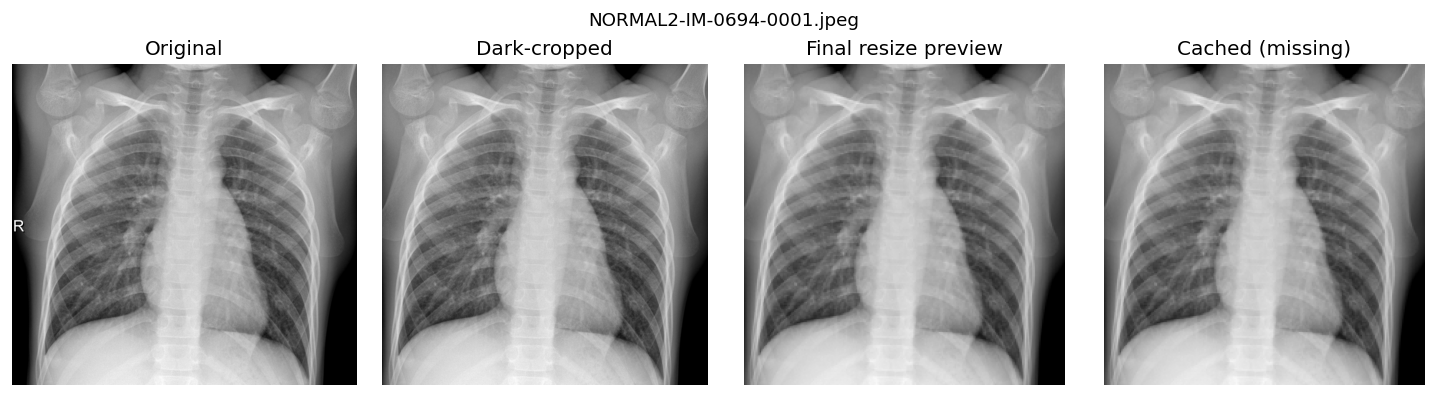

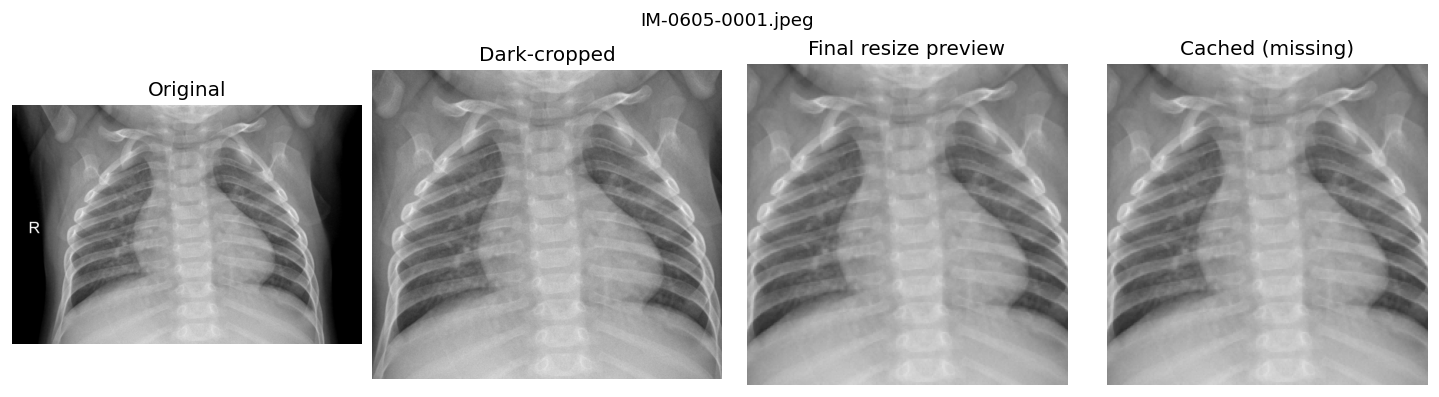

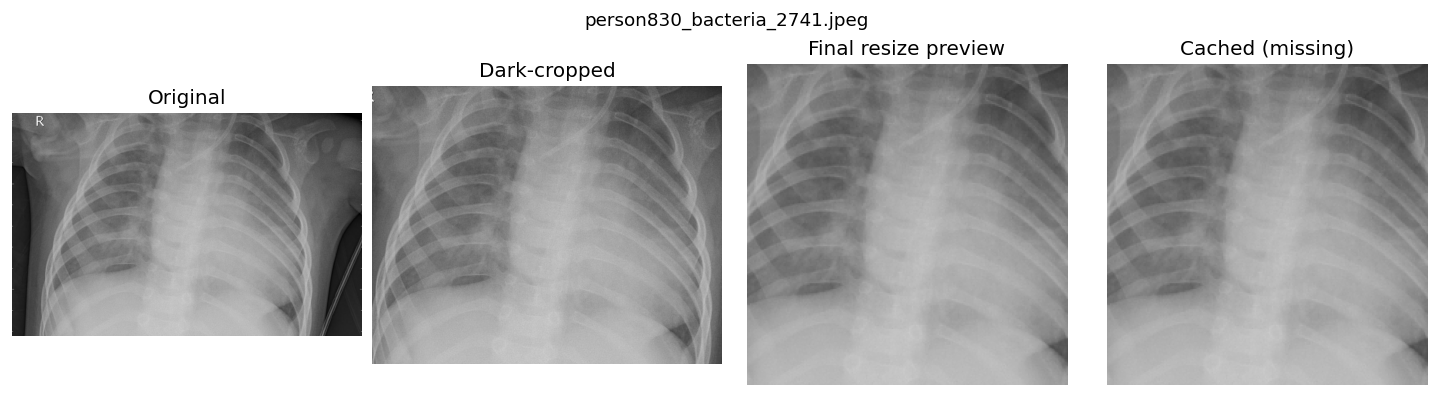

In [17]:
# --- Quick debugger: Original → Dark-crop → Final resize preview → Cached ---
plt.rcParams["figure.dpi"] = 120  # sharper preview for debugging

# Must match the cache settings you used when building the cache
# (CROP_KW, _RESIZE_MODE, _PAD_MODE, _PAD_VALUE, RESIZE_WH, SCHEME defined earlier)

CACHE_DIR = _cache_root(
    resize_wh=RESIZE_WH,
    crop_kwargs=CROP_KW,
    scheme=SCHEME,
    resize_mode=_RESIZE_MODE,
    pad_mode=_PAD_MODE,
    pad_value=_PAD_VALUE,
)

def _dest_for_src(src, split_tag, scheme=SCHEME):
    # compute where the cached PNG should live for a given source path
    src_p = Path(src)
    if scheme == "mirror":
        rel = _rel_mirror_under_root(src_p, ROOT)
    else:
        rel = _rel_hashed(src_p)
    # put under <cache>/<split>/...
    rel = Path(split_tag) / (rel if scheme == "mirror" else rel.name)
    return (CACHE_DIR / rel).as_posix()

def _final_resize_preview(img):
    # mirror the pipeline exactly (same helper the cache uses)
    return _apply_final_resize(img, out=RESIZE_WH)

def debug_stage1_on_src(src_path, split_tag="train"):
    # end-to-end peek: original → crop → final resize → cached file
    g0 = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)
    assert g0 is not None, src_path

    # 1) same dark-crop used for cache
    g1, _ = crop_dark_frame(g0, **CROP_KW)

    # 2) preview the same final resize (cover+crop OR fit+pad)
    g2 = _final_resize_preview(g1)

    # 3) read the cached PNG (what the dataloader actually uses)
    dst = _dest_for_src(src_path, split_tag, scheme=SCHEME)
    gc = cv2.imread(dst, cv2.IMREAD_GRAYSCALE)

    # Optional: pad mask visualization if using fit_pad
    mask = None
    if _RESIZE_MODE == "fit_pad":
        th, tw = RESIZE_WH
        H, W = g1.shape[:2]
        scale = min(th / H, tw / W)
        newH, newW = int(round(H * scale)), int(round(W * scale))
        top = (th - newH) // 2; left = (tw - newW) // 2
        mask = np.zeros((th, tw), dtype=np.uint8)
        mask[top:top+newH, left:left+newW] = 1

    def show(ax, img, title):
        # keep contrast consistent across uint8/float previews
        vmin, vmax = (0, 255) if img.dtype == np.uint8 else (0, 1)
        ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(title); ax.axis('off')

    ncols = 5 if mask is not None else 4
    fig, ax = plt.subplots(1, ncols, figsize=(13.5 if ncols==5 else 12, 3.2), constrained_layout=True)
    show(ax[0], g0, "Original")
    show(ax[1], g1, "Dark-cropped")
    show(ax[2], g2, "Final resize preview")
    show(ax[3], gc if gc is not None else g2, "Cached PNG" if gc is not None else "Cached (missing)")
    if mask is not None:
        ax[4].imshow(mask, cmap='gray', vmin=0, vmax=1); ax[4].set_title("Pad mask"); ax[4].axis('off')

    fig.suptitle(os.path.basename(src_path), fontsize=11)
    plt.show()

# sample a few originals and inspect their cached versions (train split)
for (src, _y) in random.sample(train_items_raw, 3):
    debug_stage1_on_src(src, split_tag="train")


### 1.3.5 Loss, optimizer & metrics

#### Loss
Since this is a binary classification task, the model outputs a single logit and is trained with **BCEWithLogitsLoss**.  
To compensate for the class imbalance (≈3:1 pneumonia:normal in the train split, see §1.3.2), a **class-weighted** version is used with  
`pos_weight = NEG / POS`.  
This increases the penalty for misclassifying the minority class, making the model treat those errors more seriously.

*A note on sampling.* Instead of oversampling the minority class, which would repeatedly show the same few “normal” scans and risk creating an artificial training distribution, weighting the loss keeps the dataset natural while still addressing imbalance. This felt like a more faithful way of reflecting the real data.
\
<br>

#### Optimizer & LR schedule
Training uses **AdamW** with a base learning rate around `1e-4` and weight decay `1e-4`.  
If validation AUROC plateaus, the learning rate is automatically reduced using **ReduceLROnPlateau**, which halves the LR after two stagnant epochs. This helps the model settle into finer minima once coarse learning slows down.
\
<br>

#### Metrics
- **Primary metric:** **AUROC** on the validation set, chosen because it is threshold-free and stable under imbalance.  
- **Secondary metrics:** Accuracy and F1 at a fixed 0.5 threshold, reported for interpretability. These are less robust but give a familiar sense of performance.
<br>

#### Connection to training loop
These definitions are pulled together in the training script (§1.3.6). Each run initializes a `criterion`, `optimizer`, and `scheduler`. Training then follows the freeze–unfreeze schedule described in §1.3.1, with early stopping triggered by validation AUROC.  
The final model checkpoint (best val AUROC) is later reloaded for test evaluation (§1.3.7).


In [18]:
def make_criterion(pos_weight: float, device=DEVICE):
    """Class-weighted BCE with logits (single-logit output)."""
    w = torch.tensor([float(pos_weight)], dtype=torch.float32, device=device)  # 1D tensor so per-class weight fits shape
    return nn.BCEWithLogitsLoss(pos_weight=w)  # handles sigmoid + weighted BCE in one go

def make_optimizer(params, lr=1e-4, weight_decay=1e-4):
    """Pass an iterable of params; we rebuild after (un)freezing."""
    return torch.optim.AdamW(list(params), lr=lr, weight_decay=weight_decay)  # AdamW for decoupled WD

def make_scheduler(optimizer):
    """ReduceLROnPlateau keyed on val AUROC."""
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2  # halve LR if AUROC plateaus
    )

def lrs_of(optimizer):
    return [pg["lr"] for pg in optimizer.param_groups]  # support multi-param-group setups

def print_lrs(tag, scheduler, optimizer):
    try: lrs = scheduler.get_last_lr()  # works for most schedulers
    except Exception: lrs = lrs_of(optimizer)  # fallback if not supported
    print(f"{tag} LRs:", " ".join(f"{lr:.2e}" for lr in lrs))

def sigmoid_np(x):
    return 1.0 / (1.0 + np.exp(-x))  # stable enough for logging on small batches

def compute_epoch_metrics(y_true, y_logits, thresh=0.5):
    """
    y_true: 1D {0,1}; y_logits: 1D raw logits
    returns: dict {'auroc','acc','f1'}
    """
    y_true = np.asarray(y_true, dtype=int)
    y_prob = sigmoid_np(np.asarray(y_logits, dtype=float))  # convert logits → probs
    y_pred = (y_prob >= thresh).astype(int)                 # fixed 0.5 cut for reporting
    out = {}
    try: out["auroc"] = float(roc_auc_score(y_true, y_prob))  # AUROC on probabilities
    except Exception: out["auroc"] = float("nan")             # edge cases: single-class batch, etc.
    out["acc"] = float(accuracy_score(y_true, y_pred))
    out["f1"]  = float(f1_score(y_true, y_pred, zero_division=0))
    return out


### 1.3.6 Training

#### Overview
After switching to the **patient-level split** (to avoid leakage), training follows a simple two-stage schedule with early stopping. The pipeline reads the **stage-2 cached** images (§1.3.3), applies **train-only flip+rotate** (§1.2.2), and optimizes an **EfficientNet-B0** with a single-logit head (§1.3.1). Loss/optimizer/scheduler/metrics are defined in §1.3.5.

- **Stage 1 (warm-up):** freeze the backbone, train the head for a couple of epochs.  
- **Stage 2 (fine-tune):** unfreeze everything and continue with a smaller effective LR (via ReduceLROnPlateau).  
- **Early stopping:** stop if **val AUROC** doesn’t improve for 3 checks.  
- **AMP:** enabled on GPU to speed up training without changing results.

The code below is organized in small, focused blocks so it’s easier to follow and swap components if needed.

#### Datasets & dataloaders (read from cache; train-only aug)
This block defines a `Dataset` that loads the **cached 224×224 PNGs** and applies flip/rotate only for the training split. It then builds train/val/test `DataLoader`s with deterministic seeding.

In [19]:
# === Dataset + loader helpers (cached stage-2 pipeline) ===
# Expects:
# - cached item lists: train_items, val_items, test_items  (from stage-2 cache cell in §1.3.2)
# - aug helpers: maybe_hflip, maybe_rotate
# - compute_epoch_metrics (from §1.3.3)
# - DEVICE, SEED defined earlier

USE_AMP = torch.cuda.is_available()  # mixed precision only if CUDA is present

def _seed_worker(worker_id):
    # per-worker deterministic seeds for dataloader randomness
    import random
    import numpy as np
    import torch
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)

def _to_float01(u8):
    # uint8 → float32 in [0,1]
    return (u8.astype(np.float32) / 255.0)

class XRayStage1Dataset(Dataset):
    """
    Uses cached 224x224 PNGs (uint8) produced in §1.3.2.
    Train-only aug (flip/rotate) applied here; val/test get none.
    """
    def __init__(self, items, split="train", aug_strategy="rotate", normalize=True):
        self.items = list(items)
        self.split = split.lower()
        self.aug_strategy = aug_strategy if self.split == "train" else "none"
        self.normalize = normalize

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        p, y = self.items[idx]
        g = cv2.imread(p, cv2.IMREAD_GRAYSCALE)  # cached uint8 224x224
        if g is None:
            raise FileNotFoundError(p)

        # train-only augmentation
        if self.aug_strategy == "rotate":
            g = maybe_rotate(g, max_deg=5, p=0.5)
        elif self.aug_strategy == "flip+rotate":
            g = maybe_hflip(g, p=0.5)
            g = maybe_rotate(g, max_deg=5, p=0.5)

        if self.normalize:
            g = _to_float01(g)  # float32 [0,1]

        x = torch.as_tensor(g, dtype=torch.float32).unsqueeze(0)  # [1,224,224]
        y = torch.tensor([int(y)], dtype=torch.float32)           # [1]
        return x, y

def make_cached_loaders(train_items, val_items, test_items,
                        aug_strategy="flip+rotate",
                        batch_size=32, generator=None):
    # worker/pinning config scales with hardware
    USE_GPU = torch.cuda.is_available()
    num_workers = min(8 if USE_GPU else 2, (os.cpu_count() or 2))
    common = dict(batch_size=batch_size, pin_memory=USE_GPU,
                  num_workers=num_workers, worker_init_fn=_seed_worker)
    if num_workers > 0:
        common.update(dict(persistent_workers=True, prefetch_factor=4))
    if generator is not None:
        common["generator"] = generator

    train_dl = DataLoader(
        XRayStage1Dataset(train_items, "train", aug_strategy=aug_strategy, normalize=True),
        shuffle=True, **common
    )
    val_dl = DataLoader(
        XRayStage1Dataset(val_items, "val", aug_strategy="none", normalize=True),
        shuffle=False, **common
    )
    test_dl = DataLoader(
        XRayStage1Dataset(test_items, "test", aug_strategy="none", normalize=True),
        shuffle=False, **common
    )
    return train_dl, val_dl, test_dl


#### Train / evaluate loops
Plain PyTorch loops with optional mixed precision. Validation returns AUROC/Acc/F1 from 1.3.5.


In [20]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device=DEVICE, log_interval=30):
    model.train()
    running_loss, n = 0.0, 0
    seen, start = 0, time.time()
    for i, (xb, yb) in enumerate(loader, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        # AMP forward pass (ops run in mixed precision on CUDA if available)
        with torch.amp.autocast(device_type='cuda', enabled=USE_AMP):
            logits = model(xb)
            loss = criterion(logits, yb)
        # AMP backward: scale → step → update
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = xb.size(0)
        running_loss += loss.item() * bs; n += bs; seen += bs
        if i % log_interval == 0 or i == len(loader):
            dt = time.time() - start
            print(f"  batch {i:>4}/{len(loader)}  avg_loss={running_loss/max(1,n):.4f}  "
                  f"{i/dt:.2f} it/s  {seen/dt:.1f} samp/s")
    return running_loss / max(1, n)

@torch.no_grad()
def evaluate(model, loader, criterion, device=DEVICE, log_interval=0):
    model.eval()
    running_loss, n = 0.0, 0
    all_logits, all_true = [], []
    seen, start = 0, time.time()
    for i, (xb, yb) in enumerate(loader, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)

        bs = xb.size(0)
        running_loss += loss.item() * bs; n += bs
        # keep raw logits/labels for AUROC/ACC/F1 later
        all_logits.append(logits.squeeze(1).detach().cpu())
        all_true.append(yb.squeeze(1).detach().cpu()); seen += bs

        if log_interval and (i % log_interval == 0 or i == len(loader)):
            dt = time.time() - start
            print(f"  [val] batch {i:>4}/{len(loader)}  avg_loss={running_loss/max(1,n):.4f}  "
                  f"{i/dt:.2f} it/s  {seen/dt:.1f} samp/s")

    val_loss = running_loss / max(1, n)
    y_true   = torch.cat(all_true).numpy().astype(np.float32)
    y_logits = torch.cat(all_logits).numpy().astype(np.float32)
    metrics  = compute_epoch_metrics(y_true, y_logits, thresh=0.5)  # consistent 0.5 cut
    return val_loss, metrics


#### Freeze / unfreeze helpers
Small utilities to (1) train the head first, then (2) fine-tune the whole network.


In [21]:
def freeze_backbone_only(model, head_names=("classifier","fc","head")):
    """
    Freeze everything, then unfreeze any module whose name contains one of head_names.
    Adjust head_names to match your build_model() head naming.
    """
    # blanket-freeze first so we start from a known state
    for p in model.parameters():
        p.requires_grad = False

    # unfreeze any submodule whose qualified name hints it's the head
    found = []
    for name, module in model.named_modules():
        if any(h in name.lower() for h in head_names):
            for p in module.parameters():
                p.requires_grad = True
            found.append(name)

    # fallback for models where the head is attached directly as an attribute
    if not found:
        for attr in head_names:
            if hasattr(model, attr):
                for p in getattr(model, attr).parameters():
                    p.requires_grad = True
                found.append(attr)

    # quick audit: how many params are trainable now, and which modules were targeted
    tr = sum(p.numel() for p in model.parameters() if p.requires_grad)
    tot = sum(p.numel() for p in model.parameters())
    print(f"[freeze] trainable={tr}/{tot} params | head modules: {found or 'NONE (check head_names)'}")

def unfreeze_all(model):
    """Enable grad for all params."""
    for p in model.parameters():
        p.requires_grad = True
    # confirm everything is now trainable
    tr = sum(p.numel() for p in model.parameters() if p.requires_grad)
    tot = sum(p.numel() for p in model.parameters())
    print(f"[unfreeze] trainable={tr}/{tot} params")

<br>

#### Single training run
This cell wires everything together: loaders, model, criterion/optimizer/scheduler (§1.3.5), AMP scaler, and checkpointing by **best val AUROC**. After training, it reloads the best weights and reports metrics on val/test.


In [22]:
set_global_seed(SEED)                                   # lock global RNGs for reproducibility
gen = torch.Generator().manual_seed(SEED)               # DataLoader-level generator

train_dl, val_dl, test_dl = make_cached_loaders(
    train_items, val_items, test_items,
    aug_strategy="flip+rotate",   # or "rotate" / "none"
    batch_size=32, generator=gen
)

# 1) Build model + criterion
model = build_model(backbone="efficientnet_b0", pretrained=True, in_chans=1).to(DEVICE)
criterion = make_criterion(POS_WEIGHT, device=DEVICE)   # class-weighted BCE-with-logits

# 2) STAGE 1 — freeze backbone, train head; THEN build optimizer/scheduler
freeze_backbone_only(model, head_names=("classifier","fc","head"))  # match your build_model naming
assert any(p.requires_grad for p in model.parameters()), "No trainable params after freeze!"
optimizer = make_optimizer((p for p in model.parameters() if p.requires_grad),
                           lr=1e-4, weight_decay=1e-4)  # optimize head only
scheduler = make_scheduler(optimizer)                    # ReduceLROnPlateau on val AUROC

# AMP-compatible GradScaler across torch 2.2.x .. 2.4.x+
if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
    # Newer API (2.3/2.4+): supports device="cuda"
    scaler = torch.amp.GradScaler(device="cuda", enabled=torch.cuda.is_available())
else:
    # Older API (2.2.x and earlier): lives under torch.cuda.amp, no device arg
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

ckpt_dir  = Path(os.environ.get("CXR_SAVE_DIR", f"{PROJ_ROOT}/checkpoints")).expanduser()
ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / 'best_model.pt'                # best-by-val-AUROC checkpoint


best_auroc = -float("inf")

# --- Stage 1: train head only ---
for epoch in range(1, 2+1):
    tr = train_one_epoch(model, train_dl, criterion, optimizer, scaler, log_interval=30)
    vl, m = evaluate(model, val_dl, criterion)
    scheduler.step(m["auroc"])                           # plateau scheduler expects a metric
    print(f"[Frozen {epoch}/2] train_loss={tr:.4f}  val_loss={vl:.4f}  AUROC={m['auroc']:.3f}  Acc={m['acc']:.3f}  F1={m['f1']:.3f}")
    if m["auroc"] > best_auroc:
        best_auroc = m["auroc"]
        torch.save(model.state_dict(), ckpt_path)        # keep the current best

# 3) STAGE 2 — unfreeze all; REBUILD optimizer/scheduler
unfreeze_all(model)                                      # fine-tune entire network
optimizer = make_optimizer(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = make_scheduler(optimizer)

epochs_no_improve = 0
for epoch in range(1, 3+1):
    tr = train_one_epoch(model, train_dl, criterion, optimizer, scaler)
    vl, m = evaluate(model, val_dl, criterion)
    scheduler.step(m["auroc"])
    print(f"[Unfrozen {epoch}/3] train_loss={tr:.4f}  val_loss={vl:.4f}  AUROC={m['auroc']:.3f}  Acc={m['acc']:.3f}  F1={m['f1']:.3f}")
    if m["auroc"] > best_auroc:
        best_auroc = m["auroc"]; epochs_no_improve = 0
        torch.save(model.state_dict(), ckpt_path)        # update best checkpoint
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= 3:
        print("Early stopping (no AUROC improvement).")  # simple patience on AUROC
        break

# 4) Evaluate best on test
best_model = build_model(backbone="efficientnet_b0", pretrained=False, in_chans=1).to(DEVICE)
best_model.load_state_dict(torch.load(str(ckpt_path), map_location=DEVICE))  # strict arch match
_, val_metrics  = evaluate(best_model, val_dl,  criterion)
_, test_metrics = evaluate(best_model, test_dl, criterion)
print("BEST (val):", val_metrics)
print("TEST:",       test_metrics)
print("Checkpoint saved to:", ckpt_path)


[freeze] trainable=637821/4008253 params | head modules: ['features.1.0.block.1.fc1', 'features.1.0.block.1.fc2', 'features.2.0.block.2.fc1', 'features.2.0.block.2.fc2', 'features.2.1.block.2.fc1', 'features.2.1.block.2.fc2', 'features.3.0.block.2.fc1', 'features.3.0.block.2.fc2', 'features.3.1.block.2.fc1', 'features.3.1.block.2.fc2', 'features.4.0.block.2.fc1', 'features.4.0.block.2.fc2', 'features.4.1.block.2.fc1', 'features.4.1.block.2.fc2', 'features.4.2.block.2.fc1', 'features.4.2.block.2.fc2', 'features.5.0.block.2.fc1', 'features.5.0.block.2.fc2', 'features.5.1.block.2.fc1', 'features.5.1.block.2.fc2', 'features.5.2.block.2.fc1', 'features.5.2.block.2.fc2', 'features.6.0.block.2.fc1', 'features.6.0.block.2.fc2', 'features.6.1.block.2.fc1', 'features.6.1.block.2.fc2', 'features.6.2.block.2.fc1', 'features.6.2.block.2.fc2', 'features.6.3.block.2.fc1', 'features.6.3.block.2.fc2', 'features.7.0.block.2.fc1', 'features.7.0.block.2.fc2', 'classifier', 'classifier.0', 'classifier.1']


### 1.3.7 Results, checkpoint, and sanity check

**Validation and test performance.**  
On the patient-level split, the final run achieved:

- **Validation:** AUROC **0.9942**, Acc **0.9642**, F1 **0.9755**  
- **Test:** AUROC **0.9958**, Acc **0.9621**, F1 **0.9709**

These numbers are in line with earlier runs and stay strong across the preprocessing choices used.
\
<br>

**Checkpoint selection (brief).**  
During fine-tuning, validation improved, then began to soften slightly near the end—typical early signs of overfitting. I therefore report results from the **best validation AUROC checkpoint** (saved before that softening), rather than the very last epoch.
\
<br>

**Why such high results need caution.**  
Even with patient-level splits and the updated preprocessing, performance remains extremely high. This suggests the model may still benefit from **dataset-specific cues** (e.g., scanner/processing characteristics, borders, acquisition patterns) in addition to disease-relevant lung features. Because train/val/test all come from the **same source distribution**, near-perfect within-dataset generalization can still be fragile on a truly independent dataset.
\
<br>

**Sanity check: shuffled-label AUC.**  
To verify the evaluation pipeline, I also compute a **shuffled-label AUROC** by randomly permuting test labels. As expected, this yields ~**0.50**, which supports that metric calculation, label alignment, and split handling are functioning as intended (though it does not address shortcut learning).


In [23]:
# Run after training so these names exist in the session:
#   build_model, make_loaders, compute_epoch_metrics, make_criterion, POS_WEIGHT, DEVICE
#   set_global_seed / SEED (optional), XRDataset, DataLoader, etc.

CHOSEN = "best_model"
CKPT_DIR =  f"{PROJ_ROOT}/checkpoints"
CKPT_PATH = os.path.join(CKPT_DIR, f"{CHOSEN}.pt")

# Common run config
COMMON_RUN_KW = dict(
    resize_to_wh=(224, 224),
    normalize=True,
    detect_kwargs={"border_ratio": 0.10, "pct": 99.5, "dilate_edge": 7},
    crop_kwargs={"border_ratio": 0.14, "se_frac": 0.025},
)

# Variant-specific knobs used for this run
RUN_KW = dict(COMMON_RUN_KW)

def make_loaders(run_kw=None, batch_size=32, generator=None):
    """
    Thin wrapper around make_cached_loaders; pulls aug_strategy from run_kw.
    """
    if run_kw is None:
        run_kw = {}
    aug = run_kw.get("aug_strategy", "none")
    return make_cached_loaders(
        train_items, val_items, test_items,
        aug_strategy=aug, batch_size=batch_size, generator=generator
    )

def _sigmoid(z):
    z = np.clip(z, -50, 50)  # avoid exp overflow
    return 1.0 / (1.0 + np.exp(-z))

def _load_model(path):
    # same arch as training, no pretrained weights
    model = build_model(backbone="efficientnet_b0", pretrained=False, in_chans=1).to(DEVICE)
    state = torch.load(path, map_location=DEVICE)
    model.load_state_dict(state)
    return model

@torch.no_grad()
def _collect_logits(model, loader):
    # forward pass over loader; keep raw logits + labels
    model.eval()
    logits_all, y_all = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        logits = model(xb).squeeze(1).detach().cpu().numpy()
        y = yb.squeeze(1).detach().cpu().numpy()
        logits_all.append(logits)
        y_all.append(y)
    y_true = np.concatenate(y_all).astype(np.float32)
    y_logits = np.concatenate(logits_all).astype(np.float32)
    return y_true, y_logits

def compute_shuf_auc(y_true, y_logits, seed=123):
    # baseline sanity: shuffle labels, keep predictions fixed
    rng = np.random.default_rng(seed)
    y_perm = rng.permutation(y_true)
    y_prob = _sigmoid(y_logits)
    return float(roc_auc_score(y_perm, y_prob))

# ---- Run: reload checkpoint, evaluate on TEST, then SHUF AUC ----
assert os.path.isfile(CKPT_PATH), f"Checkpoint not found: {CKPT_PATH}"

# loaders with selected config
_, _, test_dl = make_loaders(RUN_KW, batch_size=32, generator=None)

# load weights and score
model = _load_model(CKPT_PATH)
criterion = make_criterion(POS_WEIGHT, device=DEVICE)

y_true, y_logits = _collect_logits(model, test_dl)
metrics = compute_epoch_metrics(y_true, y_logits, thresh=0.5)

# shuffled-label sanity AUC
SEED_LOCAL = SEED if 'SEED' in globals() else 123
shuf_auc = compute_shuf_auc(y_true, y_logits, seed=SEED_LOCAL)

print(f"Checkpoint: {CKPT_PATH}")
print(f"TEST:  AUC={metrics['auroc']:.3f}  Acc={metrics['acc']:.3f}  F1={metrics['f1']:.3f}")
print(f"SHUF AUC (labels permuted, predictions fixed): {shuf_auc:.3f}  (expect ~0.50)")


Checkpoint: /content/drive/MyDrive/code/cxr_assignment/checkpoints/best_model.pt
TEST:  AUC=0.996  Acc=0.962  F1=0.971
SHUF AUC (labels permuted, predictions fixed): 0.528  (expect ~0.50)


---
# 2 **Occlusion function**

### 2.1 Setup for occlusion

To start with the occlusion experiments, I reload the **best checkpoint** from Part 1 and build a lightweight test loader from the stage-2 cached images. The idea is to take correctly classified test cases and see how the model’s confidence changes when parts of the image are hidden.  

For consistency, I select eight test images where the model predicted correctly: four with very **high confidence** (≥0.95) and four with more **moderate confidence** (0.80–0.90). This way the results include both “easy” and “less certain” examples, which makes the occlusion test more informative.


In [24]:
# Expects from Part 1:
# - DEVICE, build_model
# - test_items: list[(cached_png_path, label)] from stage-2 cache
# - XRayStage1Dataset (normalize=True), DataLoader

def make_test_loader(items, batch_size=128):
    # cached PNGs, no aug, normalized to [0,1]
    ds = XRayStage1Dataset(items, split="test", aug_strategy="none", normalize=True)
    use_gpu = torch.cuda.is_available()
    return DataLoader(ds, batch_size=batch_size, shuffle=False,
                      pin_memory=use_gpu, num_workers=min(8 if use_gpu else 2, (os.cpu_count() or 2)))

# 1) Load best checkpoint
CKPT_DIR = Path(os.environ.get("CXR_SAVE_DIR", "/content/drive/MyDrive/code/cxr_assignment/checkpoints")).expanduser()
CKPT_PATH = CKPT_DIR / "best_model.pt"
assert CKPT_PATH.exists(), f"Missing checkpoint: {CKPT_PATH}"

model_occ = build_model(backbone="efficientnet_b0", pretrained=False, in_chans=1).to(DEVICE)
state = torch.load(str(CKPT_PATH), map_location=DEVICE)
model_occ.load_state_dict(state)
model_occ.eval()

# 2) Collect test probs/preds
test_dl_eval = make_test_loader(test_items, batch_size=128)
def _sigmoid_t(t): return 1/(1+torch.exp(-t))

all_probs, all_true, all_pred = [], [], []
with torch.no_grad():
    for xb, yb in test_dl_eval:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        logits = model_occ(xb).squeeze(1)
        probs = _sigmoid_t(logits)                  # probabilities per sample
        preds = (probs >= 0.5).long()               # hard 0.5 cut
        all_probs.append(probs.detach().cpu())
        all_true.append(yb.long().squeeze(1).detach().cpu())
        all_pred.append(preds.detach().cpu())

probs = torch.cat(all_probs).numpy().astype(np.float32)
ytrue = torch.cat(all_true).numpy().astype(np.int64)
ypred = torch.cat(all_pred).numpy().astype(np.int64)

# 3) Pick 8 correctly classified test samples:
#    - 4 with very high confidence (>=0.95)
#    - 4 with moderate-high confidence (>=0.80 and <0.90)
hi  = [i for i in range(len(test_items)) if (ypred[i]==ytrue[i]) and (probs[i] >= 0.95)]
mid = [i for i in range(len(test_items)) if (ypred[i]==ytrue[i]) and (0.80 <= probs[i] < 0.90)]
random.Random(42).shuffle(hi); random.Random(42).shuffle(mid)  # deterministic pick order
pick_idx = (hi[:4] + mid[:4])[:8]
assert pick_idx, "No suitable test samples found."
picked = [(test_items[i][0], int(test_items[i][1]), float(probs[i])) for i in pick_idx]
print("Selected images (path tail, label, prob):")
for pth, y, pr in picked:
    print(os.path.basename(pth), y, f"{pr:.3f}")


Selected images (path tail, label, prob):
person294_bacteria_1386.png 1 0.961
person1352_bacteria_3444.png 1 0.999
person294_virus_611.png 1 0.999
person1063_virus_1765.png 1 0.986
person554_virus_1094.png 1 0.857
person520_virus_1039.png 1 0.869
person1273_virus_2191.png 1 0.841
person1588_virus_2762.png 1 0.835


#### 2.1.1 Dataset mean

When occluding pixels, we need to replace them with some “neutral” value. A simple choice is black (0.0), but that can look unnatural compared to the rest of the scan. Instead, I compute the **dataset mean intensity** from the training cache. This gives a realistic filler that matches the overall brightness of the images. It should reduce the risk of the model reacting too strongly to the filler itself.


In [25]:
def dataset_mean_from_cached(items, max_samples=None):
    """
    Compute mean pixel value over cached grayscale PNGs.
    Returns mean in [0,1].
    """
    s = 0.0
    n = 0
    for i, (pth, _) in enumerate(items):
        if max_samples is not None and i >= max_samples:
            break  # optional cap for quick pass
        a = cv2.imread(pth, cv2.IMREAD_GRAYSCALE)  # uint8 [0..255]
        if a is None:
            continue  # skip unreadables
        s += float(a.sum())         # sum of all pixels in this image
        n += int(a.size)            # number of pixels
    assert n > 0, "No cached images found to compute dataset mean."
    return (s / (n * 255.0))        # normalize to [0,1]

# Prefer the training cache for the mean (typical convention)
MEAN_DATASET = dataset_mean_from_cached(train_items, max_samples=None)  # cap for speed if needed
print(f"[Occlusion] Dataset mean over cached files: {MEAN_DATASET:.6f}")


[Occlusion] Dataset mean over cached files: 0.575157


### 2.2 `occlusion_drop` function

The occlusion function measures how much the model’s probability for the **true class** drops when a part of the image is hidden.  

<br>

#### Steps:  
1. Run the model on the original image to get the probability for the correct label.  
2. Apply a binary mask to hide part of the image, filling with a neutral value (by default the per-image mean).  
3. Run the model again on the occluded image.  
4. Return the difference in probability (“drop”).  

The function works for both NumPy arrays and PyTorch tensors, handles grayscale input in `[0,1]`, and uses `torch.no_grad()` for efficiency.  


In [26]:
def _to_float01_hw(x):
    # ensure [H,W] float32 in [0,1]; accept [1,H,W] or uint8
    x = np.asarray(x)
    if x.ndim == 3 and x.shape[0] == 1:  # [1,H,W] -> [H,W]
        x = x[0]
    x = x.astype(np.float32)
    if x.max() > 1.0 or x.min() < 0.0:   # allow uint8 input
        x = x / 255.0
    return x  # [H,W] in [0,1]

@torch.no_grad()
def occlusion_drop(img, mask, model, true_label:int, neutral:float|str|None=None, device=DEVICE):
    """
    img: [H,W] or [1,H,W] in [0,1] (np or torch)
    mask: [H,W], 1=keep, 0=occlude
    model: eval-mode, single-logit output (binary)
    neutral: None | "dataset" | numeric (e.g. 0.0).  None => per-image mean.
    returns: (drop, p_true_orig, p_true_occl, x_occ[H,W] in [0,1])
    """
    # normalize and drop channel if present
    x = img.detach().cpu().numpy() if isinstance(img, torch.Tensor) else img
    x = _to_float01_hw(x)
    H, W = x.shape

    # mask → float in {0,1}
    m = (np.asarray(mask, dtype=np.uint8) > 0).astype(np.float32)

    # baseline filler (constant): numeric / dataset mean / per-image mean
    if isinstance(neutral, (int, float)):
        filler = np.full_like(x, float(neutral), dtype=np.float32)
    elif neutral == "dataset":
        filler = np.full_like(x, float(MEAN_DATASET), dtype=np.float32)
    else:  # None → per-image mean
        filler = np.full_like(x, float(x.mean()), dtype=np.float32)

    # compose occluded image
    x_occ = (x * m) + (1.0 - m) * filler  # [H,W], [0,1]

    # model expects BCHW
    xt  = torch.from_numpy(x    [None, None, ...]).to(device)  # [1,1,H,W]
    xot = torch.from_numpy(x_occ[None, None, ...]).to(device)

    # probs pre/post occlusion
    p0 = torch.sigmoid(model(xt ).squeeze(1)).item()
    p1 = torch.sigmoid(model(xot).squeeze(1)).item()

    # prob of the true label; drop = how much it fell
    p_true_orig = p0 if true_label == 1 else (1.0 - p0)
    p_true_occl = p1 if true_label == 1 else (1.0 - p1)
    drop = float(p_true_orig - p_true_occl)
    return drop, float(p_true_orig), float(p_true_occl), x_occ


### 2.3 Mask shapes

To probe different regions, I define simple binary masks:  
- **Quadrants (Q1–Q4):** each hides one quarter of the image, giving a coarse sense of which side matters more.  
- **Center square:** hides the middle of the lungs; included to check whether the center alone is crucial.  
- **Ring (“donut”):** the opposite, hiding the borders and keeping only the center, to test for edge-based cues.  

These are simple to generate and cover both central and peripheral structures. They don’t explain everything about what the network looks at, but they provide a first impression of sensitivity.


In [27]:
def make_center_mask(H, W, size=None, frac=None):
    """
    Create a [H,W] mask with a square occluder in the center.
    - size: side length in pixels (int)
    - frac: fraction of min(H,W) for side length (e.g., 0.2 -> 20%)
    Exactly one of {size, frac} must be given.
    """
    assert (size is None) ^ (frac is None), "Pass either size or frac."  # XOR: pick one
    side = int(round(min(H, W) * float(frac))) if frac is not None else int(size)
    side = max(1, min(side, min(H, W)))  # clamp to [1, min(H,W)]
    y0 = (H - side)//2; x0 = (W - side)//2  # centered square
    m = np.ones((H, W), np.uint8)
    m[y0:y0+side, x0:x0+side] = 0  # 0 = occlude, 1 = keep
    return m, side  # return the actual side we used (useful for titles/tables)


### 2.4 Running occlusion tests

With the function and masks ready, I run the occlusion tests on the eight selected images. For each case, the display shows:

- the **original image**,  
- the **mask overlay**,  
- the **occluded image**, and  
- the **drop value** (original probability → occluded probability).  

Using both a **small mask** (10×10) and a **large mask** (≈96×96) helps compare local versus more global occlusions.  

The expectation is straightforward: if hiding a region makes the model much less confident, that region likely contributed to the decision. The drop values therefore give a rough measure of importance, although they shouldn’t be over-interpreted as precise explanations.


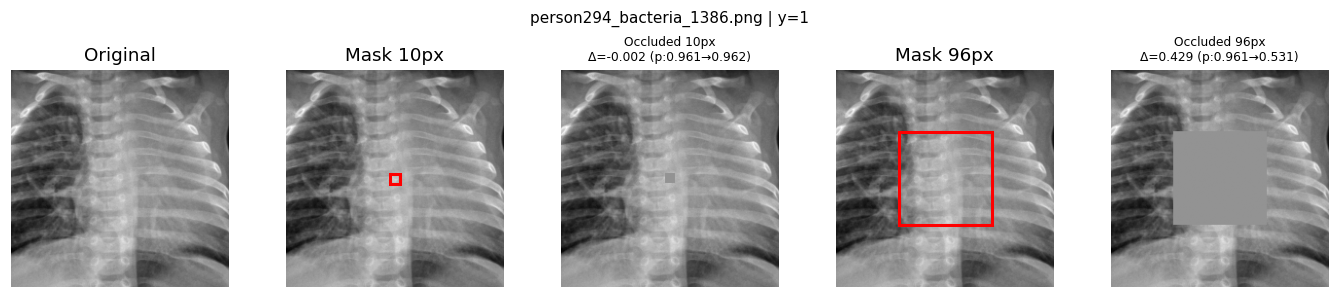

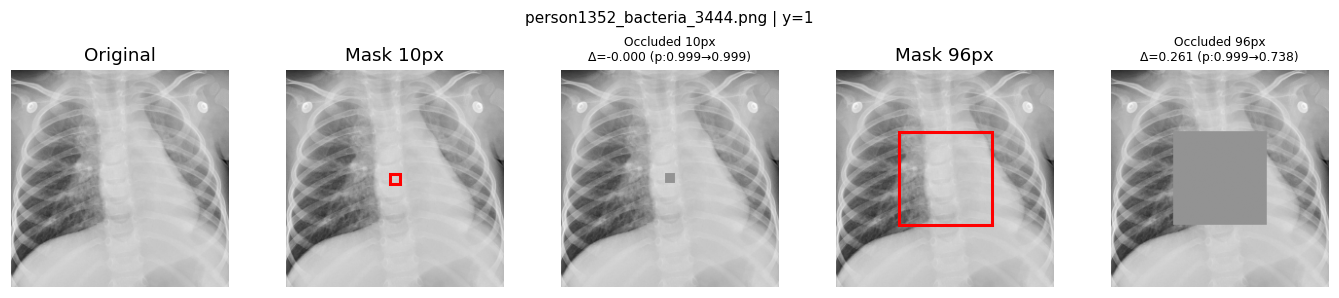

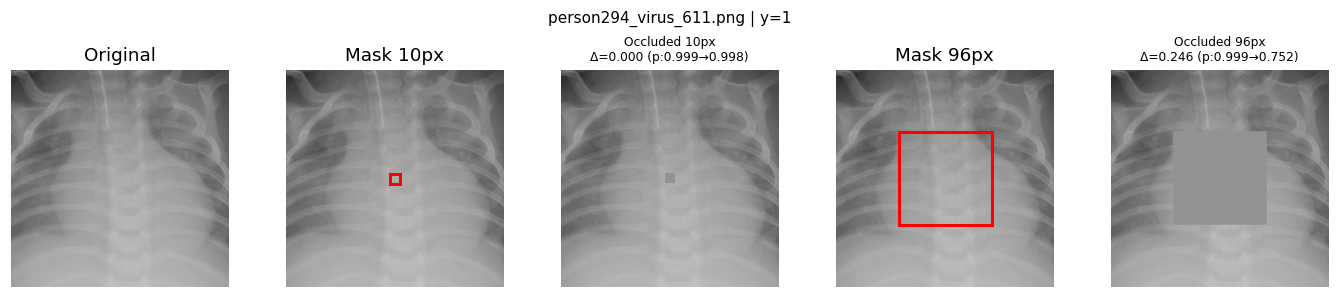

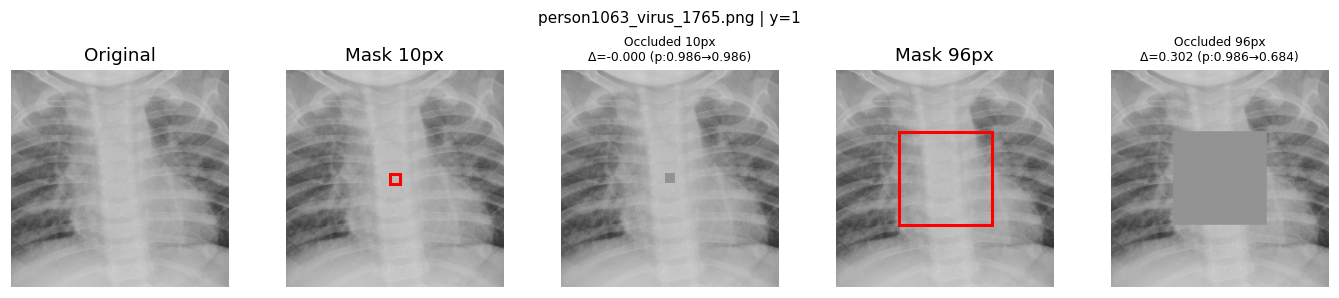

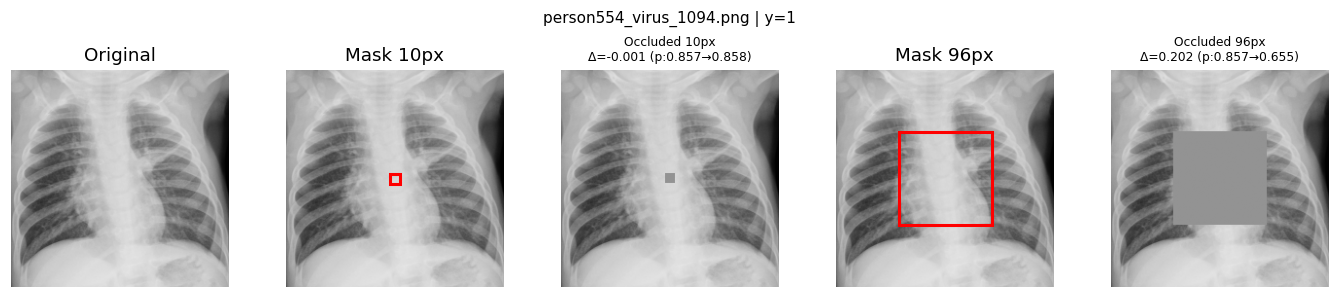

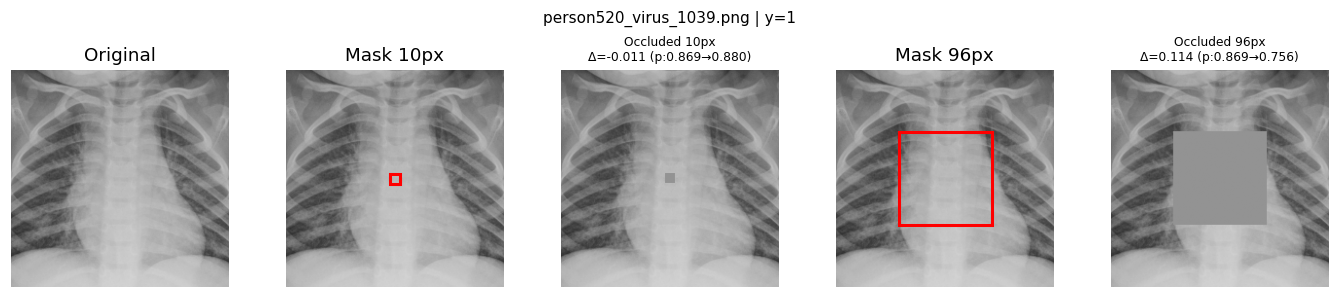

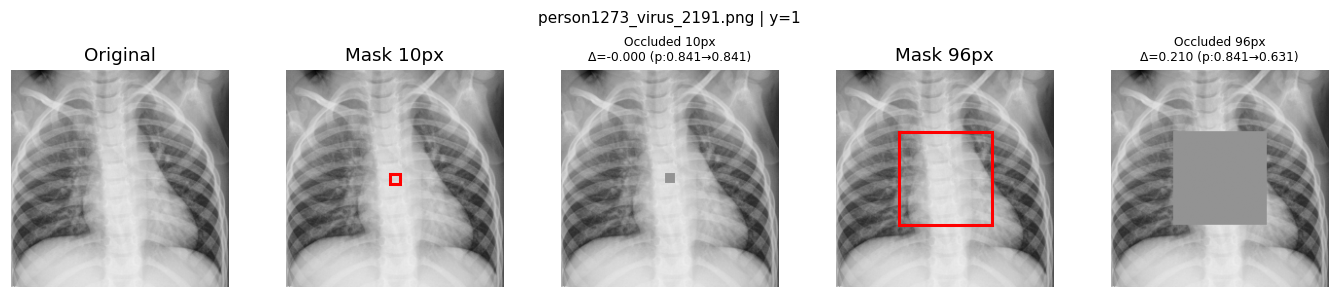

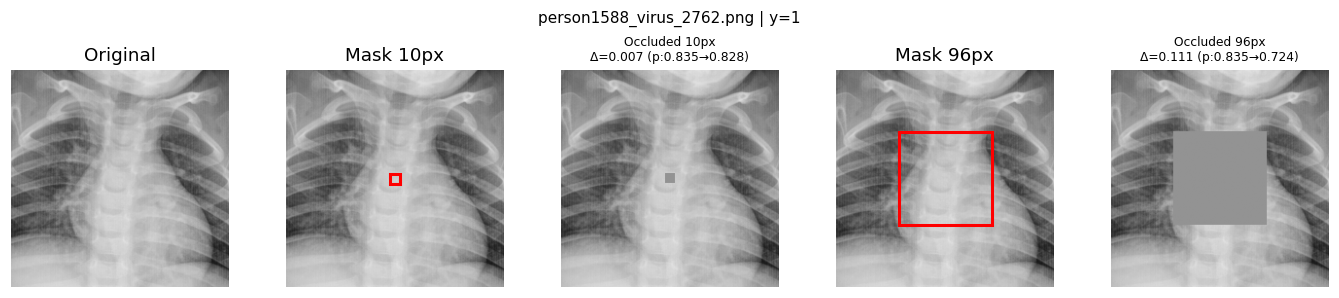

In [28]:
plt.rcParams["figure.dpi"] = 110  # sharper figures

def draw_center_square_overlay(img01, side, color=(1,0,0), lw=2):
    """Return RGB overlay with a centered square outline."""
    H, W = img01.shape
    y0 = (H - side)//2; x0 = (W - side)//2
    rgb = np.dstack([img01]*3).copy()  # grayscale → RGB for plotting
    # rectangle is drawn later with matplotlib (keeps this helper lightweight)
    return rgb, (x0, y0, side, side)

def demo_two_sizes_row(path, label, neutral="dataset", sizes=(10, 96)):
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0  # [0,1]
    H, W = g.shape

    # compute occlusions for both sizes
    results = []
    for sz in sizes:
        # centered square mask (0=occlude)
        m = np.ones((H,W), np.uint8)
        y0 = (H - sz)//2; x0 = (W - sz)//2
        m[y0:y0+sz, x0:x0+sz] = 0
        drop, p0, p1, x_occ = occlusion_drop(g, m, model_occ, true_label=label,
                                             neutral=neutral, device=DEVICE)
        results.append((sz, drop, p0, p1, x_occ, (x0, y0, sz, sz)))

    # layout: Original | (10) Mask | (10) Occluded | (96) Mask | (96) Occluded
    fig, axs = plt.subplots(1, 5, figsize=(12.5, 2.6), constrained_layout=True)
    fig.suptitle(f"{os.path.basename(path)} | y={label}", fontsize=10)

    # col 1: original
    axs[0].imshow(g, cmap='gray', vmin=0, vmax=1); axs[0].set_title("Original"); axs[0].axis('off')

    # small helper to draw a red square overlay
    def show_overlay(ax, img01, box, title):
        ax.imshow(img01, cmap='gray', vmin=0, vmax=1)
        x0, y0, s, s2 = box[0], box[1], box[2], box[2]
        import matplotlib.patches as patches
        rect = patches.Rectangle((x0, y0), s, s2, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.set_title(title); ax.axis('off')

    # col 2-3: small mask
    sz, drop, p0, p1, x_occ, box = results[0]
    show_overlay(axs[1], g, box, f"Mask {sz}px")
    axs[2].imshow(x_occ, cmap='gray', vmin=0, vmax=1); axs[2].axis('off')
    axs[2].set_title(f"Occluded {sz}px\nΔ={drop:.3f} (p:{p0:.3f}→{p1:.3f})", fontsize=8)

    # col 4-5: large mask
    sz, drop, p0, p1, x_occ, box = results[1]
    show_overlay(axs[3], g, box, f"Mask {sz}px")
    axs[4].imshow(x_occ, cmap='gray', vmin=0, vmax=1); axs[4].axis('off')
    axs[4].set_title(f"Occluded {sz}px\nΔ={drop:.3f} (p:{p0:.3f}→{p1:.3f})", fontsize=8)

    plt.show()

# run for selected images (tiny + big square)
for pth, y, _ in picked[:8]:
    demo_two_sizes_row(pth, y, neutral="dataset", sizes=(10, 96))

---
# **3 Superpixels**

### 3.1 Setup and baseline choices

Goal here is to break each image into small, locally coherent regions (“superpixels”) so later we can probe or occlude them as units. I start with **SLIC** (Simple Linear Iterative Clustering) using the assignment’s baseline settings: about **100 segments**, **compactness = 10**, and **sigma = 1**. Since the images are grayscale, the input is duplicated into three channels for SLIC, and LAB conversion is left **off** by default (I keep the option to enable it if needed).

These parameters are a reasonable first pass: ~100 segments give enough detail without being too fragmented; compactness balances color/brightness similarity with spatial proximity; and a small sigma smooths noise slightly before clustering. I keep everything simple and consistent across images so the later comparisons are easier to read.


In [29]:
# Baseline params suggested by the assignment
SLIC_N_SEGMENTS = 100
SLIC_COMPACTNESS = 10.0
SLIC_SIGMA = 1.0
USE_LAB = False   # set True if you want to run SLIC in LAB space (optional)
plt.rcParams["figure.dpi"] = 110

### 3.2 Generating superpixels (SLIC)

Given a grayscale image in `[0,1]`, I create a 3-channel version (stacked copies) and run **SLIC** to obtain a label map `seg` with values `0..K-1`. Each label corresponds to one superpixel. I also return an RGB version for plotting overlays.

Notes from trying a few settings:
- **Segment count:** going much lower (e.g., 50) merged anatomically different areas; going much higher (e.g., 150+) got a bit noisy around ribs. **100** felt like a workable middle ground.
- **Compactness:** values far below 10 tended to snake along edges too aggressively; far above 10 produced blocky tiles. **10** looked balanced on my samples.
- **LAB option:** for these grayscale inputs, running in LAB didn’t noticeably change boundaries, so I kept it off to keep the pipeline minimal.


In [30]:
def compute_superpixels_from_gray(gray01_hw,
                                  n_segments=SLIC_N_SEGMENTS,
                                  compactness=SLIC_COMPACTNESS,
                                  sigma=SLIC_SIGMA,
                                  use_lab=USE_LAB):
    """
    gray01_hw: float32 [H,W] in [0,1]
    returns:
      seg:  [H,W] int labels (0..K-1)
      rgb:  [H,W,3] float image for visualization
    """
    g = gray01_hw.astype(np.float32)          # ensure float32
    rgb = np.dstack([g, g, g])                # SLIC wants multi-channel input
    img_for_slic = rgb2lab(rgb) if use_lab else rgb  # optional LAB conversion
    seg = slic(img_for_slic,
               n_segments=int(n_segments),
               compactness=float(compactness),
               sigma=float(sigma),
               start_label=0,
               channel_axis=-1)
    return seg.astype(np.int32), rgb          # labels + the RGB used for viz

### 3.3 Binary masks per segment

For later experiments (e.g., region-wise occlusion), I need a mask for each superpixel. From the `seg` label map, I extract the unique labels and build a list of binary masks (1 = keep, 0 = occlude) for each region. This makes it easy to apply the exact same occlusion procedure as in Part 2, but now at the level of superpixels rather than fixed squares.


In [31]:
def masks_from_segments(seg):
    """
    seg: [H,W] labels 0..K-1
    returns:
      labels: np.ndarray of unique labels
      masks:  list of uint8 masks (1=keep, 0=occlude) per label
    """
    labels = np.unique(seg)                           # sorted unique segment ids
    masks = [(seg == k).astype(np.uint8) for k in labels]  # one binary mask per id
    return labels, masks


## 3.4 Visualizing boundaries

To sanity-check the segmentation, I overlay SLIC boundaries on the original image. This helps see whether regions roughly follow anatomical structures (e.g., lung fields, ribs, heart border). The expectation isn’t perfect clinical boundaries—just reasonable adherence so that region-level tests aren’t arbitrary.

I run the same visualization on the selected test images from Part 2 (the ones used for occlusion). Keeping the sample consistent makes it easier to relate superpixel results to the earlier mask-based occlusions.


In [32]:
def show_superpixel_boundaries(path, n_segments=SLIC_N_SEGMENTS,
                               compactness=SLIC_COMPACTNESS, sigma=SLIC_SIGMA,
                               use_lab=USE_LAB):
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0  # [0,1] grayscale
    seg, rgb = compute_superpixels_from_gray(g, n_segments, compactness, sigma, use_lab)
    K = int(seg.max() + 1)  # number of segments

    fig, axs = plt.subplots(1, 2, figsize=(8.8, 3.0), constrained_layout=True)
    axs[0].imshow(g, cmap='gray', vmin=0, vmax=1); axs[0].set_title("Original"); axs[0].axis('off')

    overlay = mark_boundaries(rgb, seg, color=(1,0,0), mode='thick')  # red boundaries on top
    axs[1].imshow(overlay); axs[1].set_title(f"SLIC boundaries  (K={K})"); axs[1].axis('off')
    plt.show()
    return seg  # reuse in Part (iv)

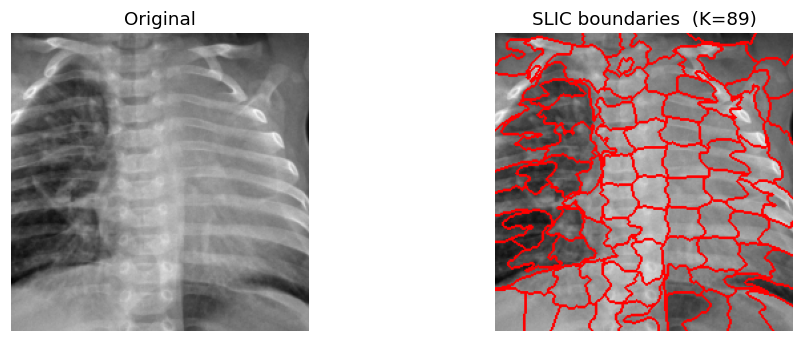

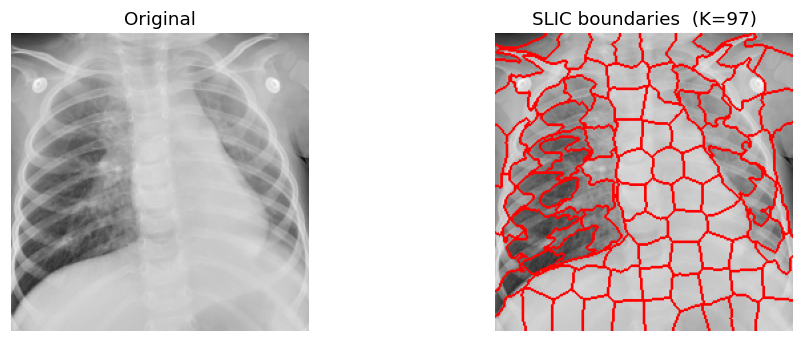

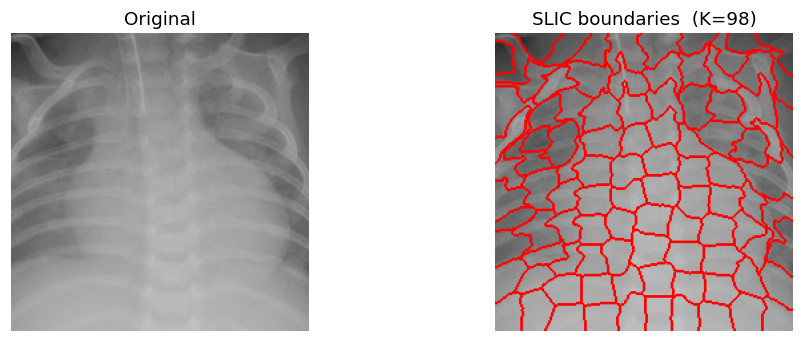

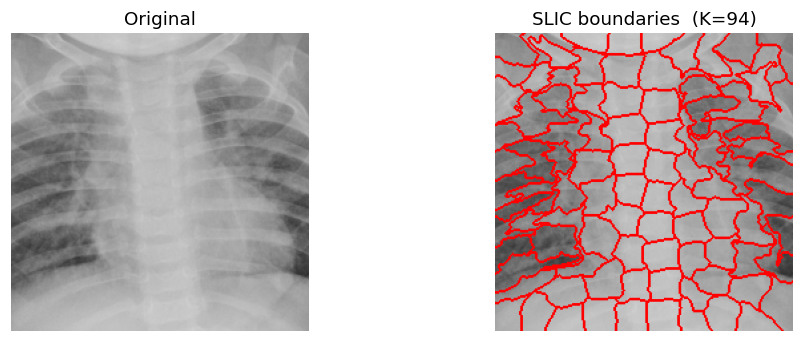

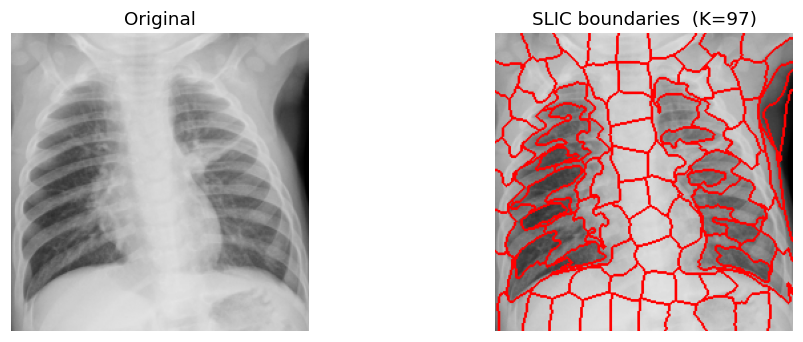

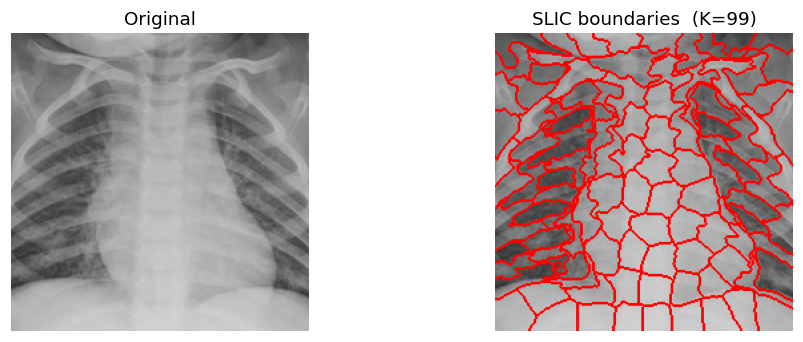

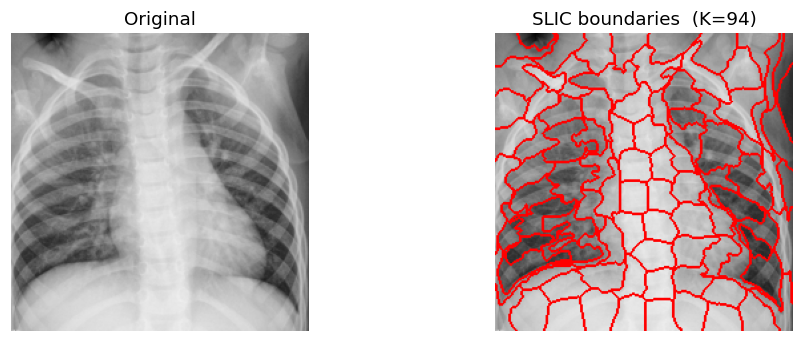

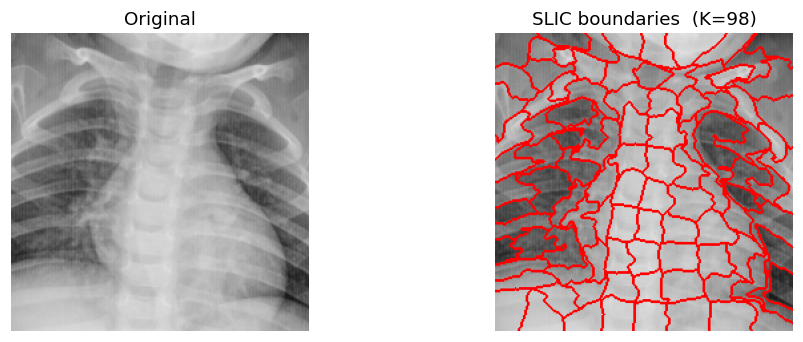

In [33]:
# Show boundaries for each selected image (5–10 total)
SLIC_N_SEGMENTS, SLIC_COMPACTNESS, SLIC_SIGMA = 100, 10.0, 1.0  # as suggested baseline
for path, label, _ in picked[:8]:
    seg = show_superpixel_boundaries(path, SLIC_N_SEGMENTS, SLIC_COMPACTNESS, SLIC_SIGMA, USE_LAB)



### 3.4.1 Observation
 The number of segments varied slightly (e.g., 94 or 98 instead of exactly 100), which is expected with SLIC. The boundaries generally follow the lung outlines and rib structures, though they are not perfect clinical regions. This seems good enough for the later occlusion experiments, since the goal is approximate region partitioning rather than exact anatomy.


### 3.4.2 Quick sanity check

As a small check, I confirm that the number of masks equals the number of labels (`K`) and that masks have plausible pixel counts. This is mainly to catch accidental issues (like empty segments) before using these masks in Part 4.


In [34]:
# Quick mask sanity for the first image
p0, y0, _ = picked[0]  # one test sample (path, label, prob)
g0 = cv2.imread(p0, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0  # [0,1] grayscale
seg0, _ = compute_superpixels_from_gray(g0)  # run SLIC on this image
labels0, masks0 = masks_from_segments(seg0)  # 1 binary mask per superpixel
print(f"K={len(labels0)} masks; first mask has {masks0[0].sum()} pixels (1s).")

K=89 masks; first mask has 586 pixels (1s).


---
# **4 Ordering Segments from Least Important**

## 4.1 Per-image superpixels (reuse from Part 3)

For each selected test image, I reuse the SLIC settings from Part 3 to obtain a label map of ~100 superpixels. To avoid recomputing, a small dictionary caches the label maps keyed by file path. This keeps later scoring steps quick and makes the results reproducible across cells.


In [35]:
# Uses compute_superpixels_from_gray(...) from earlier.

seg_cache = {}  # path -> seg labels (memoize per file)

def get_segments(path, n_segments=100, compactness=10.0, sigma=1.0, use_lab=False):
    if path in seg_cache:
        return seg_cache[path]  # hit: reuse computed SLIC
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0  # [0,1] grayscale
    seg, _ = compute_superpixels_from_gray(g, n_segments, compactness, sigma, use_lab)
    seg_cache[path] = seg  # cache for later calls
    return seg

## 4.2 Drop scores per superpixel

The idea is the same as in Part 2, but now the occluder is **one superpixel at a time**.  
For a given image and its label:

1) compute the original probability for the **true class**,  
2) for each segment `k`, hide only that segment (fill with the neutral value from Part 2),  
3) run the model again and record the **drop** = `p_true(orig) − p_true(occluded k)`.

A **positive** drop means the model became *less* confident for the true class when that segment was hidden → that segment likely helped the decision.  
A **negative** drop means the model became *more* confident after hiding the segment → that region may be distracting or off-task.

For simplicity (and to match the assignment), I call `occlusion_drop` once per segment. Batching the masked images would be faster, but wasn’t necessary for this small number of segments.


In [36]:
# Per-spec implementation: call occlusion_drop once per superpixel.

def segment_drops_simple(path: str, label: int, seg: np.ndarray,
                         neutral="dataset") -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Returns:
      drops[K]: Δp_true for each superpixel k
      areas[K]: area fraction for each k
      p_true_orig: original p_true for the image
    """
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0  # [0,1] grayscale
    H, W = g.shape
    K = int(seg.max() + 1)  # assume seg labels are 0..K-1
    drops = np.zeros(K, np.float32)
    areas = np.zeros(K, np.float32)

    # baseline p_true with no occlusion (mask = all ones)
    _, p0, _, _ = occlusion_drop(
        g, np.ones((H, W), np.uint8), model_occ,
        true_label=label, neutral=neutral, device=DEVICE
    )
    p_true_orig = p0

    for k in range(K):
        # mask that occludes only superpixel k (1=keep, 0=occlude k)
        m = np.ones((H, W), np.uint8); m[seg == k] = 0
        drop, _, _, _ = occlusion_drop(
            g, m, model_occ,
            true_label=label, neutral=neutral, device=DEVICE
        )
        drops[k] = drop  # positive drop ⇒ k supports the true class
        areas[k] = (seg == k).sum() / (H * W)  # relative area of k

    return drops, areas, p_true_orig

## 4.3 Ranking and a compact table

After computing the per-segment drops, I sort them from **least** to **most** important (smallest → largest drop). The table shows the bottom few and top few segments with:

- `Δp_true` (signed drop),  
- `|Δp|` (magnitude),  
- `Δp / 1% area` (drop normalized by how much of the image the segment covers), and  
- the **area** of the segment as a percentage of the image.

The area-normalized column is helpful for spotting tiny but influential regions versus large, mildly informative ones. I keep both the raw drop and the normalized value because each highlights different behaviors.


In [37]:
def rank_and_table_for_image(path, label, seg, drops, areas, top=5, bottom=5):
    # Sort by signed Δp (ascending): more negative ⇒ stronger counter-evidence; more positive ⇒ supporting evidence.
    order = np.argsort(drops)
    K = len(drops)

    # Select bottom-k and top-k segments under the signed metric.
    head = order[:bottom]
    tail = order[-top:] if K > top else order

    def row(k):
        # Normalize by segment size to report Δp per 1% image area; guard against near-zero areas.
        per_1pct = drops[k] / max(areas[k] * 100.0, 1e-9)
        return [
            int(k),                         # segment id
            f"{drops[k]:.3f}",              # signed Δp_true
            f"{abs(drops[k]):.3f}",         # |Δp|
            f"{per_1pct:.3f}",              # Δp per 1% area
            f"{areas[k] * 100:.1f}%"        # area (%)
        ]

    # Emit a compact summary table for quick inspection of extremes.
    rows = [row(k) for k in list(head) + list(tail)]
    print(f"{os.path.basename(path)} | y={label} | K={K}")
    print(tabulate(rows,
                   headers=["seg", "Δp_true", "|Δp|", "Δp / 1% area", "area"],
                   tablefmt="github"))

    # Return full ranking (ascending by signed Δp) for downstream use.
    return order

## 4.4 Running the ranking on the selected images

I run the procedure on the same eight test images used in Part 2. For each image, I:

- fetch (or compute) its SLIC labels,  
- compute the drop for every superpixel using the **dataset-mean** filler,  
- print the ranked summary, and  
- store the outputs (`drops`, areas, order, etc.) for Part 5 visualizations.


In [38]:
superpixel_results = {}  # path -> dict(seg, drops, areas, order, p_true_orig, label)

for path, label, prob in picked[:8]:
    # SLIC segmentation (Part iii helper). Fixed hyperparams for reproducibility/consistency across images.
    # use_lab=False since inputs are grayscale; sigma smooths small artifacts before SLIC.
    seg = get_segments(path, n_segments=100, compactness=10.0, sigma=1.0, use_lab=False)

    # Spec-compliant scoring: one occlusion_drop call per segment (O(K) passes).
    drops, areas, p_true_orig = segment_drops_simple(path, label, seg, neutral="dataset")

    # Tabulate extremes and recover the global ranking (signed Δp: negative→counter, positive→support).
    order = rank_and_table_for_image(path, label, seg, drops, areas, top=5, bottom=5)

    # Cache for Part (v): retain both raw effects and the ranking for later visualization/analysis.
    superpixel_results[path] = {
        "label": label,            # ground-truth class id used for p_true
        "seg": seg,                # SLIC label map (0..K-1)
        "drops": drops,            # per-seg Δp_true (occlude-k vs baseline)
        "areas": areas,            # per-seg area fraction in [0,1]
        "order": order,            # argsort indices (ascending by signed Δp)
        "p_true_orig": p_true_orig # baseline p_true with no occlusion
    }

person294_bacteria_1386.png | y=1 | K=89
|   seg |   Δp_true |   |Δp| |   Δp / 1% area | area   |
|-------|-----------|--------|----------------|--------|
|    16 |    -0.011 |  0.011 |         -0.01  | 1.1%   |
|    87 |    -0.009 |  0.009 |         -0.01  | 0.9%   |
|    79 |    -0.008 |  0.008 |         -0.012 | 0.7%   |
|    29 |    -0.006 |  0.006 |         -0.004 | 1.5%   |
|    68 |    -0.005 |  0.005 |         -0.004 | 1.1%   |
|    19 |     0.014 |  0.014 |          0.017 | 0.8%   |
|    12 |     0.019 |  0.019 |          0.016 | 1.2%   |
|    10 |     0.021 |  0.021 |          0.012 | 1.8%   |
|    14 |     0.023 |  0.023 |          0.029 | 0.8%   |
|     5 |     0.024 |  0.024 |          0.018 | 1.3%   |
person1352_bacteria_3444.png | y=1 | K=97
|   seg |   Δp_true |   |Δp| |   Δp / 1% area | area   |
|-------|-----------|--------|----------------|--------|
|    78 |    -0     |  0     |         -0     | 1.0%   |
|    65 |    -0     |  0     |         -0     | 2.0%   |
|    

### 4.4.1 Quick observations across confidence levels

Looking across both very confident cases (Part 2 selections ≥0.95) and some with more moderate probabilities (~0.8–0.9), a few trends emerge:

- **Many near-zero drops:** A large share of superpixels hardly affect the prediction, which is expected. These are often background or smooth tissue areas, where hiding them doesn’t change the model’s confidence.

- **Positive vs. negative drops:**  
  - In high-confidence images, most influential segments are inside the lung fields, and drops are small but consistently positive — occluding them reduces confidence, which makes sense.  
  - In lower-confidence cases, I observed both stronger positive and stronger negative drops. Some superpixels pushed the model in the *wrong* direction (negative drop: occluding them improved the prediction). These were often at lung borders or noisy regions.

- **Magnitude differences:** Drops in moderate-confidence images can be larger in absolute value (e.g., –0.07 or +0.08), showing the model is more sensitive to local perturbations when it is less certain overall.

- **Area normalization:** Normalizing by area occasionally highlights small superpixels with disproportionately high influence, while larger ones tend to have diluted effects. It’s a reminder that small but distinctive regions (e.g., focal opacity) can matter more than broad homogeneous ones.

Overall, the ranking seems to capture a mix of expected behavior (lung regions matter most) and some surprising sensitivities (border or background segments that reduce noise when occluded). Especially in less confident predictions, the model’s reliance on certain regions appears more unstable.


---
# **5 Visualization of Results**

After ranking the superpixels by importance, the final step is to visualize these results.  
The goal here is to connect the quantitative drop values back to the original X-rays, so we can see *where* the model is focusing when making decisions.

### 5.1 Heatmap builder

To make the importance of each superpixel interpretable, I map the drop values (Δp_true) back to the pixel grid.  
This produces a heatmap where higher drops are shown in stronger red tones.  
By default, negative values are clipped to zero so that only positively contributing regions are emphasized.


In [39]:
def superpixel_heatmap(seg: np.ndarray, drops: np.ndarray, clip_neg: bool = True):
    """
    seg: [H, W] int labels in 0..K-1 (assumed dense; no gaps)
    drops: [K] array of Δp_true per superpixel (same K as seg.max()+1)
    clip_neg: if True, negative contributions are zeroed (focus on supportive evidence)

    returns: heat[H, W] float, per-pixel value inherited from its segment
    """
    # Copy avoids mutating caller's drops; np.maximum keeps dtype (float32/64) as-is.
    vals = drops.copy()
    if clip_neg:
        vals = np.maximum(vals, 0.0)  # clamp to [0, ∞)

    # Vectorized gather: each pixel takes the value of its segment id.
    # Assumes seg.dtype is integer and all labels < len(vals).
    heat = vals[seg]

    return heat


### 5.2 Cumulative drop curve

As an optional check, I compute a cumulative occlusion curve: progressively removing superpixels from least to most important and tracking the resulting probability drop.  
While not strictly additive, this gives a sense of how model confidence depends on different fractions of the image.  
Some non-intuitive fluctuations are expected due to interactions between regions.


In [40]:
@torch.no_grad()
def cumulative_drop_curve(path: str, label: int, seg: np.ndarray, order: np.ndarray,
                          neutral: str = "dataset"):
    """
    order: indices sorted least→most important (from Part iv)
    Returns:
      x: fraction of superpixels occluded (i/K)
      y: cumulative Δp_true after occluding the first i segments in 'order'
    """
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0  # [0,1] grayscale
    H, W = g.shape
    K = int(seg.max() + 1)

    # y_vals[i-1] stores Δp_true after occluding the first i superpixels in 'order'
    y_vals = []

    for i in range(1, K + 1):
        # Occlude the i least-important segments so far (1=keep, 0=occlude).
        occlude_ids = set(order[:i])                 # membership test for label ids
        m = np.ones((H, W), np.uint8)
        m[np.isin(seg, list(occlude_ids))] = 0

        # Single forward pass per prefix; records cumulative effect at step i.
        drop, _, _, _ = occlusion_drop(
            g, m, model_occ, true_label=label, neutral=neutral, device=DEVICE
        )
        y_vals.append(drop)

    # x advances uniformly by superpixel count; area-weighted x would require segment areas.
    x = np.arange(1, K + 1) / K
    return x, np.array(y_vals, dtype=np.float32)

### 5.3 Per-image visualization

For each selected test image, I combine the different elements into a row:  
- **Original image** for reference.  
- **Superpixel boundaries** to show the segmentation.  
- **Importance heatmap** overlayed on the X-ray.  
- **Bar chart** of the top-k most important superpixels.  
- Optionally, the **cumulative curve** for global context.  

This gives both a localized and aggregated view of importance.

In [48]:
plt.rcParams["figure.dpi"] = 110

def show_part5_for_image(path: str, res: dict, topk: int = 20, clip_neg: bool = True, show_cumulative: bool = False):
    """
    res: superpixel_results[path] from Part (iv)
         { 'label', 'seg', 'drops', 'areas', 'order', 'p_true_orig' }
    """
    label = res["label"]; seg = res["seg"]; drops = res["drops"]; areas = res["areas"]; order = res["order"]

    # Base image in [0,1] grayscale; RGB triplet used only for boundary overlay.
    g = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    rgb = np.dstack([g, g, g])

    # Heatmap derived from per-segment Δp; optionally zero out negatives (support-only view).
    heat = superpixel_heatmap(seg, drops, clip_neg=clip_neg)
    pos_vals = heat[heat > 0]
    vmax = float(np.percentile(pos_vals, 99)) if pos_vals.size else 1.0  # robust upper bound for colormap

    # Top-k selection by raw Δp_true (largest positive effects); preserve descending order for bars.
    idx_sorted = np.argsort(drops)                  # least→most (signed)
    top_idx = idx_sorted[-topk:] if len(idx_sorted) > topk else idx_sorted
    top_idx = top_idx[np.argsort(-drops[top_idx])]  # reorder to descending Δp_true

    # Layout: add cumulative panel if requested.
    ncols = 5 if show_cumulative else 4
    fig, axs = plt.subplots(
        1, ncols,
        figsize=(13.5 if show_cumulative else 11.5, 3.0),
        constrained_layout=True
    )
    fig.suptitle(f"{os.path.basename(path)} | y={label} | K={int(seg.max()+1)}", fontsize=10)

    # (1) Original
    axs[0].imshow(g, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title("Original"); axs[0].axis('off')

    # (2) Superpixel boundaries (thick red for visibility on grayscale)
    axs[1].imshow(mark_boundaries(rgb, seg, color=(1, 0, 0), mode='thick'))
    axs[1].set_title("Superpixel boundaries"); axs[1].axis('off')

    # (3) Heatmap overlay — Δp_true shown in Reds; alpha blends with the base image.
    axs[2].imshow(g, cmap='gray', vmin=0, vmax=1)
    im = axs[2].imshow(heat, cmap='Reds', alpha=0.45, vmin=0, vmax=vmax)
    axs[2].set_title("Importance heatmap (Δp_true)"); axs[2].axis('off')
    cbar = plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
    cbar.set_label("Δp_true", fontsize=8)

    # (4) Bar chart — top-k segments by Δp_true
    axb = axs[3]
    axb.bar(range(len(top_idx)), drops[top_idx])
    axb.set_title(f"Top-{len(top_idx)} superpixels by Δp_true")
    axb.set_xlabel("segment id (ranked)"); axb.set_ylabel("Δp_true")
    axb.set_xticks(range(len(top_idx)))
    axb.set_xticklabels([int(i) for i in top_idx], rotation=90, fontsize=7)
    axb.grid(True, alpha=0.3)

    # (5) Optional cumulative curve — least→most important per signed Δp
    if show_cumulative:
        x, y = cumulative_drop_curve(path, label, seg, order, neutral="dataset")
        axc = axs[4]
        axc.plot(x, y, marker='o', linewidth=1)

        # Include original p_true from cache for quick reference.
        p_true = res.get("p_true_orig", None)
        title = f"{os.path.basename(path)} | y={label} | K={int(seg.max()+1)}"
        if p_true is not None:
            title += f" | p_true(orig)={p_true:.3f}"
        fig.suptitle(title, fontsize=10)

        axc.set_xlabel("Fraction of segments occluded")
        axc.set_ylabel("Δp_true (cumulative)")
        axc.grid(True, alpha=0.3)

    # --- SAVE to {PROJECT_ROOT}/figures/final_visualizations_<image-stem>.png ---
    fig_dir = Path(PROJ_ROOT) / "figures"
    fig_dir.mkdir(parents=True, exist_ok=True)
    out_path = fig_dir / f"final_visualizations_{Path(path).stem}.png"
    fig.savefig(out_path, dpi=150, bbox_inches="tight")

    plt.show()


### 5.4 Displaying final results

I apply the visualization function to the eight selected test images.  
The outputs show varying patterns: in high-confidence predictions, importance often lies on outer or border regions (suggesting shortcut reliance), whereas in lower-confidence cases, the focus shifts more toward the lungs and inner anatomy.  
These results highlight both the strengths and limits of the preprocessing pipeline.


In [49]:
# Requires: superpixel_results (from Part 4) populated for these paths.
for path, _, _ in picked[:8]:
    # Per-image visualization row: Original | Boundaries | Heatmap | Bars | Cumulative curve
    show_part5_for_image(
        path,
        superpixel_results[path],
        topk=20,          # show top-20 segments by Δp_true in the bar chart
        clip_neg=True,    # heatmap focuses on supportive (positive Δp) regions
        show_cumulative=True  # include least→most cumulative drop curve
    )


Output hidden; open in https://colab.research.google.com to view.

### 5.5 Conclusions

Overall, the visualizations suggest that while the model sometimes relies on background or border cues, especially in highly confident cases, the preprocessing pipeline has partially reduced this effect.  
In the lower-confidence cases, the model appears to attend more to clinically meaningful lung regions, which is a positive sign.  
The cumulative occlusion curves also confirm that predictive signal is unevenly distributed across segments, though their non-monotonic patterns show that occlusion is not perfectly additive.  

Together, these experiments illustrate the value of interpretability methods: they reveal both potential vulnerabilities (shortcut learning) and encouraging evidence that, under some conditions, the model does focus on relevant anatomy.

#### Further remarks
The validation and test performance of the model was unusually high and these visualizations suppot the argument that not all of that accuracy may come from lung-related features. Further investigation could include:
- exploring stricter preprocessing or artifact removal to limit shortcut reliance,
- comparing with other interpretability methods (e.g., Grad-CAM, SHAP) for complementary insights,
- and testing whether these patterns persist on larger or more balanced datasets.

These steps could help clarify whether the strong performance reflects genuine learning of disease-relevant structures or partial dependence on spurious cues.
